<a href="https://colab.research.google.com/github/shavonne-sw/grid-disruption-analytics/blob/main/Grid_Disruption_Simulation%2C_Risk_Classification_%26_Customer_Impact_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grid Disruption Simulation, Risk Classification & Customer Impact Analytics**

> This analysis models how potential disruptions to the electrical grid propagate through the network, classifies risk levels across different areas, and quantifies the resulting impact on customers. It transforms complex outage simulations into actionable intelligence for decision-makers.

### Who This Helps

- Utility planners can spot weak points in the network and decide where upgrades will make the most difference.  
- Regulators can check how resilient the grid really is and whether it meets required standards.  
- Emergency response teams can identify which areas are most at risk and plan crews and equipment accordingly.  
- Policy-makers and investors can see where funding could prevent the biggest losses.  


### Why It’s Important
- The grid is under more pressure than ever from tougher weather, older equipment, and changes in how and when people use electricity.  

- A fault in one place can quickly spread, leaving far more people without power than you might expect.  

- Without a clear picture of where the real risks are, time and money can be spent in the wrong places, leaving the most serious problems unsolved.

---

## 1. Dataset

draws on three data sources:


- **[Environment for the Analysis of Geo-Located Energy Information (EAGLE-I)](https://figshare.com/articles/dataset/The_Environment_for_Analysis_of_Geoocated_Energy_Information_s_Recorded_Electricity_Outages_2014-2022/24237376)**
  - County-level power outage data from 2014 to 2023, recorded at 15-minute intervals, covering over 146 million customer records.

- **[Electric Emergency Incident Disturbance Report (DOE-417)](https://www.eia.gov/electricity/data/disturbance/disturb_events_archive.html)**  
  - Records major grid disturbances and emergency incidents, supporting event attribution and severity assessment.

- **[Annual Estimates of the Resident Population for Counties (CO-EST2024-POP)](https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html)**  
  - Provides current county population figures to contextualise outage impacts.


The dataset has been aggregated and correlated with specific events to facilitate the analysis of power outages across the US.



---

## 2. Exploratory & Spatial Analysis

- **Geospatial mapping:**  
  Interactive maps and bubble plots display the frequency and category of outage events by state and county, revealing regional hotspots and spatial patterns. Spatial smoothing/ clustering applied to reduce noise in hotspot detection.
- **Top event analysis:**  
  States and counties with the highest historical outage frequency and customer impact are identified for targeted scenario planning.

---

## 3. Predictive Risk Modelling

- **Outage severity prediction:**  
  Machine learning models (XGBoost, LightGBM) estimate the number of customers affected (regression) and classify outages by risk band (Critical, Monitor, Routine, Unflagged) using calibrated predictions.
- **Duration estimation:**  
  Outage duration (hours) is predicted using regression and classified into actionable bands (Routine, Long, Prolonged) to support restoration resource planning.
- **Feature importance:**  
  SHAP analysis quantifies the contribution of event type, location, and lag features to predicted risk, guiding operational focus.

---

## 4. Rare Event and Class Imbalance

- **Class balancing:**  
  Class balancing: In the test set, Critical outages are 1.30% of events (<2%) yet 25.28% of impact (IR≈76:1); Prolonged-duration outages are 3.46% (IR≈28:1). Class weights and SMOTE (train-only) were used with calibrated probabilities and threshold tuning aligned to these base rates to reduce missed criticals.
  
- **Hybrid modelling:**  
  Two-stage models combine classification (routine vs. long/prolonged) with conditional regression for duration, improving accuracy for rare, high-risk scenarios.

---

## 5. Scenario-Based Simulation & Uncertainty Quantification

- **Scenario impact simulation:**  
  The pipeline enables "what if" analysis by simulating outage impact and duration for specific event types and regions (e.g., weather in Florida, grid issue in Texas), based on historical patterns and trained models.
- **Bootstrap and Monte Carlo analysis:**  
  Uncertainty in predictions is quantified via resampling and repeated simulations, providing confidence intervals for mean and maximum customer impact and outage duration.
- **Spatial risk summary:**  
  County-level summaries identify localised risk concentrations, supporting targeted resilience planning and resource allocation.

---

## 6. Operational Reporting & Decision Support

- **Actionable outputs:**  
  Results are delivered as risk bands, predicted restoration times, and customer impact estimates, enabling triage and prioritisation for operators.
- **Visual dashboards:**  
  Interactive charts, maps, and tables highlight risk concentrations, event distributions, and scenario outcomes to support real-time decision-making.
- **Resource allocation:**  
  Insights inform crew and material estimation for restoration planning, especially in nuclear and critical infrastructure contexts.
- **Scenario outputs:**  
  Simulated events aid contingency planning, stress-testing grid resilience, and stakeholder communication.

---





## **1. Exploratory Data Analysis (EDA) and Data Preprocessing**

In [ ]:
df_model = pd.read_csv("df_model.csv", parse_dates=["start_time"])

In [ ]:
df_model.head()

,event_id,state_event,Datetime Event Began,Datetime Restoration,Event Type,fips,state,county,start_time,duration,...,mean_customers,year,lag8_event_count,lag8_total_customers,lag8_max_customers,lag24_event_count,lag24_total_customers,lag24_max_customers,within_8h_event,within_24h_event
0,Alabama-0,Alabama,2023-01-12 14:00:00,2023-01-13 03:00:00,Severe Weather,1001,Alabama,Autauga,2023-01-12 19:00:00,52.00,...,1259.716346,2023,1.0,6873.0,6873.0,1.0,6873.0,6873.0,1,1
1,Alabama-0,Alabama,2023-01-12 14:00:00,2023-01-13 03:00:00,Severe Weather,1003,Alabama,Baldwin,2023-01-12 15:45:00,1.25,...,340.800000,2023,2.0,1823.0,1107.0,2.0,1823.0,1107.0,1,1
2,Alabama-0,Alabama,2023-01-12 14:00:00,2023-01-13 03:00:00,Severe Weather,1003,Alabama,Baldwin,2023-01-12 19:15:00,3.00,...,557.916667,2023,2.0,1823.0,1107.0,2.0,1823.0,1107.0,1,1
3,Alabama-0,Alabama,2023-01-12 14:00:00,2023-01-13 03:00:00,Severe Weather,1007,Alabama,Bibb,2023-01-13 04:00:00,7.25,...,448.827586,2023,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Alabama-0,Alabama,2023-01-12 14:00:00,2023-01-13 03:00:00,Severe Weather,1009,Alabama,Blount,2023-01-12 16:30:00,3.50,...,413.571429,2023,1.0,778.0,778.0,1.0,778.0,778.0,1,1


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526165 entries, 0 to 526164
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   event_id               526165 non-null  object        
 1   state_event            526165 non-null  object        
 2   Datetime Event Began   526165 non-null  object        
 3   Datetime Restoration   526165 non-null  object        
 4   Event Type             526165 non-null  object        
 5   fips                   526165 non-null  int64         
 6   state                  526165 non-null  object        
 7   county                 526165 non-null  object        
 8   start_time             526165 non-null  datetime64[ns]
 9   duration               526165 non-null  float64       
 10  end_time               526165 non-null  object        
 11  min_customers          526165 non-null  float64       
 12  max_customers          526165 non-null  floa

In [ ]:
# Function to clean and categorize outage event types
def clean_outage_event_type(evt):
    if not isinstance(evt, str):
        return "other"

    e = evt.lower().strip()

    # Fix common typos and normalise text
    replacements = {
        "sever weather": "severe weather",
        "transmisison": "transmission",
        "vandalism\xa0": "vandalism",
        " transmission interruption": "transmission interruption",
        "suspicious activity ": "suspicious activity",
        "vandalism ": "vandalism",
        "weather or natural disaster - other": "severe weather",
        "weather or natural disaster": "severe weather",
    }
    for old, new in replacements.items():
        e = e.replace(old, new)

    # Grouping logic
    if any(word in e for word in [
        "severe weather", "winter storm", "hurricane", "tornado",
        "thunderstorm", "flood", "rain", "snow", "heat", "wind", "wildfire"
    ]):
        return "weather"
    elif any(word in e for word in ["vandalism", "physical attack", "sabotage", "theft"]):
        return "attack"
    elif "cyber" in e:
        return "cyber"
    elif "fuel" in e:
        return "fuel"
    elif any(word in e for word in [
        "system operation", "generator", "transmission", "distribution"
    ]):
        return "grid issue"
    elif "unknown" in e:
        return "unknown"
    else:
        return "other"

# Apply event type grouping to your merged DataFrame
df_model['event_type_grouped'] = df_model['Event Type'].apply(clean_outage_event_type)

In [ ]:
# Ensure state is lowercase
df_model['state'] = df_model['state'].str.lower()

# Count number of events per (state, grouped event type)
grouped_event_counts = (
    df_model.groupby(['state', 'event_type_grouped'])
    .size()
    .reset_index(name='Count')
)

# Sort all combinations by count descending
grouped_event_counts_sorted = grouped_event_counts.sort_values(by='Count', ascending=False)

# Display top 30 combinations
display(grouped_event_counts_sorted.head(30))

,state,event_type_grouped,Count
197,texas,weather,162607
96,michigan,weather,70702
41,florida,weather,33766
20,california,weather,28995
194,texas,grid issue,14847
17,california,grid issue,12527
14,california,attack,12014
148,north carolina,weather,10274
71,kentucky,weather,9374
144,new york,weather,8173


In [ ]:
import numpy as np

# Feature Engineering

# Temporal features
df_model['event_weekday'] = df_model['start_time'].dt.dayofweek
df_model['event_hour'] = df_model['start_time'].dt.hour
df_model['is_weekend'] = df_model['event_weekday'].isin([5,6]).astype(int)

# Log transformation of customer counts
df_model['log_mean_customers'] = np.log1p(df_model['mean_customers'])
df_model['log_max_customers'] = np.log1p(df_model['max_customers'])

# Customer impact ratio
df_model['customer_impact_ratio'] = df_model['mean_customers'] / (df_model['max_customers'] + 1e-6)

df_model['min_customers'] = df_model['min_customers'].round(0).astype(int)
df_model['max_customers'] = df_model['max_customers'].round(0).astype(int)
df_model['mean_customers'] = df_model['mean_customers'].round(0).astype(int)

# Duration buckets
bins = [0, 1, 6, 24, np.inf]
labels = ['<1h', '1-6h', '6-24h', '>24h']
df_model['duration_bucket'] = pd.cut(df_model['duration'], bins=bins, labels=labels)

# Region encoding
region_map = {
    'alabama': 'south', 'alaska': 'west', 'arizona': 'west', 'arkansas': 'south',
    'california': 'west', 'colorado': 'west', 'connecticut': 'northeast', 'delaware': 'south',
    'florida': 'south', 'georgia': 'south', 'hawaii': 'west', 'idaho': 'west',
    'illinois': 'midwest', 'indiana': 'midwest', 'iowa': 'midwest', 'kansas': 'midwest',
    'kentucky': 'south', 'louisiana': 'south', 'maine': 'northeast', 'maryland': 'south',
    'massachusetts': 'northeast', 'michigan': 'midwest', 'minnesota': 'midwest', 'mississippi': 'south',
    'missouri': 'midwest', 'montana': 'west', 'nebraska': 'midwest', 'nevada': 'west',
    'new hampshire': 'northeast', 'new jersey': 'northeast', 'new mexico': 'west', 'new york': 'northeast',
    'north carolina': 'south', 'north dakota': 'midwest', 'ohio': 'midwest', 'oklahoma': 'south',
    'oregon': 'west', 'pennsylvania': 'northeast', 'rhode island': 'northeast', 'south carolina': 'south',
    'south dakota': 'midwest', 'tennessee': 'south', 'texas': 'south', 'utah': 'west',
    'vermont': 'northeast', 'virginia': 'south', 'washington': 'west', 'west virginia': 'south',
    'wisconsin': 'midwest', 'wyoming': 'west'
}
df_model['region'] = df_model['state'].map(region_map)

# Data Cleaning: Drop Redundant Columns

df_model.drop(columns=['event_id', 'state_event', 'fips'], inplace=True)

# Datetime columns parsed
df_model['Datetime Event Began'] = pd.to_datetime(df_model['Datetime Event Began'], errors='coerce')
df_model['Datetime Restoration'] = pd.to_datetime(df_model['Datetime Restoration'], errors='coerce')
df_model['end_time'] = pd.to_datetime(df_model['end_time'], errors='coerce')

# Remove leading and trailing single quotes

for col in ['state', 'county', 'Event Type']:
    df_model[col] = df_model[col].str.strip("'")

for col in ['state', 'county', 'Event Type']:
    df_model[col] = df_model[col].str.strip("'\"")


### **Spatial Analysis: Interactive geospatial map of US power outages**

In [ ]:
import plotly.express as px
import numpy as np

# Create an interactive geospatial bubble map of US power outages to visualise frequency and category of events

# US state centroids dictionary
state_centroids = {
    'alabama': (32.806671, -86.791130),
    'alaska': (61.370716, -152.404419),
    'arizona': (33.729759, -111.431221),
    'arkansas': (34.969704, -92.373123),
    'california': (36.116203, -119.681564),
    'colorado': (39.059811, -105.311104),
    'connecticut': (41.597782, -72.755371),
    'delaware': (39.318523, -75.507141),
    'district of columbia': (38.897438, -77.026817),
    'florida': (27.766279, -81.686783),
    'georgia': (33.040619, -83.643074),
    'hawaii': (21.094318, -157.498337),
    'idaho': (44.240459, -114.478828),
    'illinois': (40.349457, -88.986137),
    'indiana': (39.849426, -86.258278),
    'iowa': (42.011539, -93.210526),
    'kansas': (38.526600, -96.726486),
    'kentucky': (37.668140, -84.670067),
    'louisiana': (31.169546, -91.867805),
    'maine': (44.693947, -69.381927),
    'maryland': (39.063946, -76.802101),
    'massachusetts': (42.230171, -71.530106),
    'michigan': (43.326618, -84.536095),
    'minnesota': (45.694454, -93.900192),
    'mississippi': (32.741646, -89.678696),
    'missouri': (38.456085, -92.288368),
    'montana': (46.921925, -110.454353),
    'nebraska': (41.125370, -98.268082),
    'nevada': (38.313515, -117.055374),
    'new hampshire': (43.452492, -71.563896),
    'new jersey': (40.298904, -74.521011),
    'new mexico': (34.840515, -106.248482),
    'new york': (42.165726, -74.948051),
    'north carolina': (35.630066, -79.806419),
    'north dakota': (47.528912, -99.784012),
    'ohio': (40.388783, -82.764915),
    'oklahoma': (35.565342, -96.928917),
    'oregon': (44.572021, -122.070938),
    'pennsylvania': (40.590752, -77.209755),
    'rhode island': (41.680893, -71.511780),
    'south carolina': (33.856892, -80.945007),
    'south dakota': (44.299782, -99.438828),
    'tennessee': (35.747845, -86.692345),
    'texas': (31.054487, -97.563461),
    'utah': (40.150032, -111.862434),
    'vermont': (44.045876, -72.710686),
    'virginia': (37.769337, -78.169968),
    'washington': (47.400902, -121.490494),
    'west virginia': (38.491226, -80.954453),
    'wisconsin': (44.268543, -89.616508),
    'wyoming': (42.755966, -107.302490)
}

# Group data by state and event_type_grouped, count occurrences
event_counts = (
    df_model
    .groupby(['state', 'event_type_grouped'])
    .size()
    .reset_index(name='Count')
)

# Add centroid lat/lon for each state
event_counts['lat'] = event_counts['state'].map(lambda x: state_centroids.get(x, (np.nan, np.nan))[0])
event_counts['lon'] = event_counts['state'].map(lambda x: state_centroids.get(x, (np.nan, np.nan))[1])

# Remove rows with missing centroids (for states not in the dictionary)
event_counts = event_counts.dropna(subset=['lat', 'lon'])

# Add small jitter to lat/lon (approx ±0.3 degrees)
np.random.seed(42)
event_counts['lat_jitter'] = event_counts['lat'] + np.random.uniform(-0.3, 0.3, size=len(event_counts))
event_counts['lon_jitter'] = event_counts['lon'] + np.random.uniform(-0.3, 0.3, size=len(event_counts))

# Bubble size scaling (sqrt helps with large count skew)
event_counts['size_scaled'] = np.sqrt(event_counts['Count'])

# Enforce a minimum bubble size so small events still show up
min_size = 5
max_size = 50

# Normalize sizes to min_size-max_size range
size_min, size_max = event_counts['size_scaled'].min(), event_counts['size_scaled'].max()
event_counts['size_final'] = ((event_counts['size_scaled'] - size_min) / (size_max - size_min)) * (max_size - min_size) + min_size

# Define custom color map for event_type_grouped categories (distinct colors)
color_map = {
    'weather': '#1f77b4',       # blue
    'grid issue': '#ff7f0e',    # orange
    'fuel': '#2ca02c',          # green
    'cyber': '#d62728',         # red
    'attack': '#9467bd',        # purple
    'unknown': '#8c564b',       # brown
    'other': '#7f7f7f'          # gray
}

# Create the scatter_geo plot
fig = px.scatter_geo(
    event_counts,
    lat='lat_jitter',
    lon='lon_jitter',
    size='size_final',
    color='event_type_grouped',
    hover_name='event_type_grouped',
    hover_data=['state', 'Count'],
    scope='usa',
    title="US Power Outages by State and Category",
    color_discrete_map=color_map,
    size_max=max_size,
    opacity=0.85,
)

# Update layout for improved visual appeal (no repeated keywords!)
fig.update_layout(
    title={
        'text': "<b>Geospatial Patterns of US Power Outages:<br>Weather, Grid Issue, Cyber, Attack, Fuel, and More</b>",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font_family="Arial Black, Arial, sans-serif",
    title_font_size=28,
    title_font_color="#1f2c56",
    height=700,
    legend_title_text='Event Type Grouped',
    title_x=0.5,
    legend=dict(
        itemsizing='constant',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1
    )
)

fig.show()

---
* Weather-related outagesdominate frequency across most states; largest clusters are in high-population/high-storm-exposure states (e.g., TX, CA, FL, Northeast corridor).

* Grid issues are widespread but generally smaller than weather bubbles, showing infrastructure-related events across many states.

* Cyber  and attack categories appear infrequently and are scattered, with notably smaller bubbles (rare events).

* Fuel-related outages appear in pockets (e.g., Gulf/Southwest), with moderate counts.

* This is frequency-based (event counts), it highlights where outages are most numerous, not necessarily most impactful.

---

In [ ]:
# Visualise Top outage events by state

import plotly.express as px

# Ensure state is lowercase
df_model['state'] = df_model['state'].str.lower()

# Count number of events per (state, grouped event type)
grouped_event_counts = (
    df_model.groupby(['state', 'event_type_grouped'])
    .size()
    .reset_index(name='Count')
)

# Sort by count descending and take top 30
top30_events = grouped_event_counts.sort_values(by='Count', ascending=False).head(10)

# Create a label for easier x-axis reading
top30_events['label'] = top30_events['state'].str.title() + ' - ' + top30_events['event_type_grouped'].str.title()

# Bar chart
fig = px.bar(
    top30_events,
    x='Count',
    y='label',
    color='event_type_grouped',
    orientation='h',
    title="<b>Top 10 Power Outage Events by State and Category</b>",
    color_discrete_map={
        'weather': '#1f77b4',
        'grid issue': '#ff7f0e',
        'fuel': '#2ca02c',
        'cyber': '#d62728',
        'attack': '#9467bd',
        'unknown': '#7f7f7f',
        'other': '#7f7f7f'
    },
)

# Improve layout
fig.update_layout(
    height=800,
    xaxis_title='Event Count',
    yaxis_title='State - Event Category',
    title_x=0.5,
    legend_title_text='Event Type Grouped',
    font=dict(size=14),
    yaxis={'categoryorder': 'total ascending'},
    margin=dict(l=150, r=30, t=60, b=30)
)

fig.show()

## **2. Power Outage Severity Prediction: Outage Duration & Restoration Time**

### **Purpose**
Develop a machine learning model to predict the duration of power outages (in hours) and restoration time for each event. The objective is to estimate how long outages will last and to classify events into actionable risk bands (“Routine”, “Long”, “Prolonged”). This enables operators to proactively allocate resources and communicate with customers.


### **Approach**

#### Supervised Regression & Classification
- **Regression:** Predict the continuous duration (hours) of each outage event.
- **Classification/Banding:** Group events into risk bands based on duration, making outputs actionable for operations.

#### **Features**
- **Event Attributes:** Event type, time of day, weekday/weekend, geographic information (state, county, region).
- **Historical Context:** Lagged event counts and customer impacts (past 8/24 hours), outage history, prior event features.
- **Seasonality:** Month, season derived from event start time.
- **No Leakage:** All features available prior to restoration.

#### **Data Splitting**
- **Temporal Split:** Data is divided into training, validation, and test sets based on event start time to simulate real-world forecasting and prevent lookahead bias.

#### **Model**

- **Base Model:** XGBoost Regressor for regression tasks; LightGBM Classifier for classification (duration bands).
- **Hyperparameter Tuning:** Performed via RandomizedSearchCV for optimal performance.
- **Transformation:** Log-transform applied to target to handle skewness in outage duration.
- **Label Encoding:** All categorical features encoded for consistency.

#### **Calibration**
- Regression outputs are calibrated, and classification thresholds are tuned to maximise recall for rare, long/prolonged outages.

#### **Risk Banding**

After predicting outage duration, each event is assigned to a risk band:
- **Routine:** Less than 8 hours.Standard procedures.
- **Long:** Between 8 and 48 hours. Elevated attention, resource planning.
- **Prolonged:** 48 hours or more. Highest priority, immediate escalation.


#### **Implementation Roadmap**

1. **Baseline:**  Multiclass model performance (Routine, Long, Prolonged).
2. **Binary Class Redefinition:**  Combine long and prolonged into a single rare class for classification.
3. **Class Imbalance Handling:**  Use SMOTE and class weights.
4. **Hybrid Model:**  Binary classifier → conditional regression to estimate duration.
5. **Threshold Tuning:**  Tune threshold to maximise rare event recall.

---


In [ ]:
!pip install xgboost
!pip install --upgrade xgboost
!pip install shap
!pip install imbalanced-learn
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.8/253.8 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

#  Temporal Split
train_cutoff = pd.Timestamp("2022-05-01")
val_cutoff = pd.Timestamp("2022-12-01")

train_df = df_model[df_model['start_time'] < train_cutoff].copy()
val_df = df_model[
    (df_model['start_time'] >= train_cutoff) &
    (df_model['start_time'] < val_cutoff)
].copy()
test_df = df_model[df_model['start_time'] >= val_cutoff].copy()

# Feature Engineering
def add_time_features(df):
    df['month'] = df['start_time'].dt.month
    df['season'] = ((df['start_time'].dt.month % 12) // 3 + 1) # 1:winter, 2:spring, etc.
    return df

for d in [train_df, val_df, test_df]:
    add_time_features(d)

# Label Encoding
cat_cols = ['event_type_grouped', 'region', 'state', 'county']
for col in cat_cols:
    le = LabelEncoder()
    le.fit(df_model[col].astype(str))  # Fit on all data for consistency
    train_df[col] = le.transform(train_df[col].astype(str))
    val_df[col] = le.transform(val_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

features = [
    'event_type_grouped', 'region', 'state', 'event_hour', 'event_weekday', 'is_weekend',
    'max_customers', 'mean_customers', 'min_customers', 'customer_impact_ratio',
    'lag8_event_count', 'lag8_total_customers', 'lag8_max_customers',
    'lag24_event_count', 'lag24_total_customers', 'lag24_max_customers',
    'within_8h_event', 'within_24h_event', 'month', 'season'
]

def get_X_y(df):
    X = df[features]
    y_log = np.log1p(df['duration'])
    return X, y_log

X_train, y_train_log = get_X_y(train_df)
X_val, y_val_log = get_X_y(val_df)
X_test, y_test_log = get_X_y(test_df)

# Hyperparameter Tuning with XGBoost
params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 5, 10]
}

xgb = XGBRegressor(random_state=42, tree_method='hist', n_jobs=-1)
search = RandomizedSearchCV(
    xgb, params, n_iter=20, scoring='neg_mean_absolute_error',
    cv=3, verbose=1, random_state=42
)
search.fit(X_train, y_train_log)

#  Evaluate on validation and test sets
best_model = search.best_estimator_

def get_metrics(X, y_log):
    y_pred_log = best_model.predict(X)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return y_true, y_pred, mae, rmse, r2

results = []
for X, y_log, label in [
    (X_val, y_val_log, "Validation"),
    (X_test, y_test_log, "Test")
]:
    y_true, y_pred, mae, rmse, r2 = get_metrics(X, y_log)
    results.append({
        "Set": label,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })
    if label == "Test":
        # Save for plotting
        y_true_test = y_true
        y_pred_test = y_pred

results_df = pd.DataFrame(results)

# Display
display(
    results_df.style
    .format({"MAE": "{:,.2f}", "RMSE": "{:,.2f}", "R2": "{:.4f}"})
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,Set,MAE,RMSE,R2
0,Validation,3.52,9.92,0.4878
1,Test,4.00,11.59,0.4042


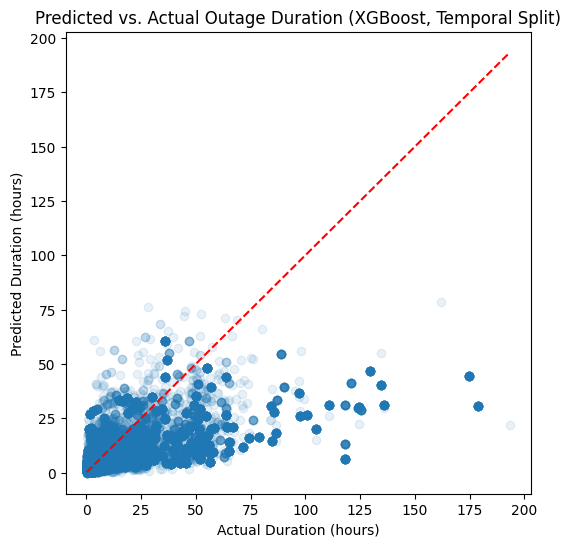

In [ ]:
# Plot: Predicted vs Actual for Test Set
plt.figure(figsize=(6,6))
plt.scatter(y_true_test, y_pred_test, alpha=0.1)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--')
plt.xlabel("Actual Duration (hours)")
plt.ylabel("Predicted Duration (hours)")
plt.title("Predicted vs. Actual Outage Duration (XGBoost, Temporal Split)")
plt.show()

-----

* These results: MAE of 3.52 hours (validation) and 4.00 hours (test); RMSE of 9.92 hours (validation) and 11.59 hours (test)—are to be interpreted in light of the dataset’s highly skewed distribution, where most outage events are short (“Routine”) and only a small fraction are long or prolonged. The scatter plot  illustrates this challenge: while the model predicts the majority of short-duration outages exceptionally well, it consistently underestimates the duration of rarer, longer events.


* This pattern is a direct consequence of optimising for average error (MAE, RMSE) on imbalanced data.

----

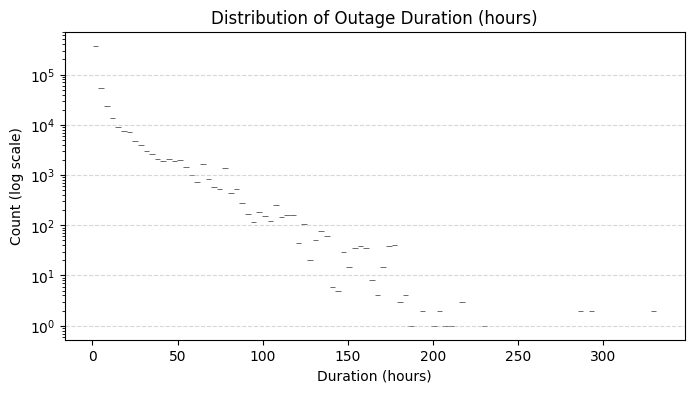

,Value
Skewness,4.71
Kurtosis,30.65


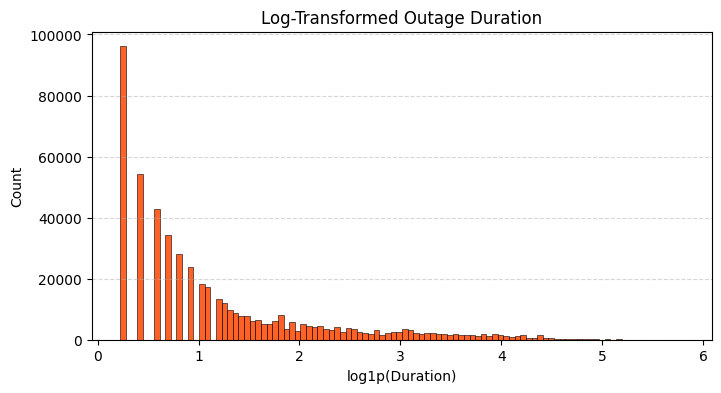

In [ ]:
# Check outage duration distribution in hours

import seaborn as sns

# Histogram of duration
plt.figure(figsize=(8,4))
sns.histplot(df_model['duration'], bins=100, log_scale=(False, True), color="dodgerblue", edgecolor="black", alpha=0.85)
plt.title('Distribution of Outage Duration (hours)')
plt.xlabel('Duration (hours)')
plt.ylabel('Count (log scale)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

# Skewness and kurtosis as a DataFrame
skew = df_model['duration'].skew()
kurt = df_model['duration'].kurtosis()
metrics_df = pd.DataFrame({
    "Value": [skew, kurt]
}, index=["Skewness", "Kurtosis"])
display(metrics_df.style.format("{:.2f}"))

# Log-transformed histogram
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df_model['duration']), bins=100, color="orangered", edgecolor="black", alpha=0.85)
plt.title('Log-Transformed Outage Duration')
plt.xlabel('log1p(Duration)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

**Data Distribution**

Analysis of the outage duration data reveals a strongly right-skewed distribution, with the overwhelming majority of events being short (“Routine”), and a very small proportion classified as “Long” or “Prolonged.”  
- Skewness (4.71) and kurtosis (30.65) confirm the presence of heavy tails and rare extreme events.
- Log-transforming the data helps visualisation, but the underlying imbalance persists.
- This level of skew is typical for outage/event duration data.

---

**Modelling Behavior**

When standard regression and classification techniques are applied to this dataset:
- Routine outages are predicted with high accuracy, as seen in the classification report (precision/recall ≈ 0.95/0.98).
- For “Long” and “Prolonged” outages, the model’s recall and precision drop significantly, with most such events misclassified as routine.
- Regression results show that model predictions cluster around the mean and systematically underestimate rare, high-duration events.


----

Given these observations, the modelling strategy incorporates the following key steps:

- Banding duration into categories (“Routine”, “Long”, “Prolonged”) enables the model to specifically identify rare, high-impact cases as a distinct task, rather than being overwhelmed by the majority class.
- Traditional metrics like MAE and RMSE, which optimise for average error, encourage the model to focus on the majority (“Routine”) class, further marginalising rare events.
- Quantile regression is considered to better capture the upper tail of the distribution. By directly modelling higher quantiles (e.g., 90th percentile), this approach aims to provide more realistic estimates for rare, long-duration outages: critical for operational planning and risk communication.


| Aspect            | Routine Events     | Long/Prolonged Events      |
|-------------------|-------------------|---------------------------|
| Data Volume       | Majority          | Rare, heavy tail          |
| Model Performance | High accuracy     | Low recall/underprediction|
| Key Metric        | MAE/RMSE (mean)   | Quantile (P90, P95)       |
| Business Impact   | Lower risk        | High risk                 |

---

This solution is designed to ensure that rare, high-impact outages are not overlooked and that the model provides actionable information for both common and extreme scenarios.

----

### **2.1 Banding (Classification)**

- Converts  the problem into a classification task (e.g., routine/long/prolonged).
- Less sensitive to extreme skew/outliers.
- Gives more actionable outputs (“This event is likely to be a long outage”).
- Easier to optimise for rare, extreme events via class weighting or resampling.

---



In [ ]:
# LightGBM classifier to predict event duration categories ("Routine", "Long", "Prolonged")

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix


def band_duration(hours):
    if hours >= 48:
        return 'Prolonged'
    elif hours >= 8:
        return 'Long'
    else:
        return 'Routine'

# Create bands in the train, validation, and test data
train_df['duration_band'] = train_df['duration'].apply(band_duration)
val_df['duration_band'] = val_df['duration'].apply(band_duration)
test_df['duration_band'] = test_df['duration'].apply(band_duration)

# Label encode the target for classifier
le_band = LabelEncoder()
train_y_band = le_band.fit_transform(train_df['duration_band'])
val_y_band = le_band.transform(val_df['duration_band'])
test_y_band = le_band.transform(test_df['duration_band'])

# Use previous features
X_train_cls = train_df[features]
X_val_cls = val_df[features]
X_test_cls = test_df[features]

# Train classifier
clf = LGBMClassifier(random_state=42, verbosity=-1)
clf.fit(X_train_cls, train_y_band)

# Predict and evaluate
test_pred_band = clf.predict(X_test_cls)
cm = confusion_matrix(test_y_band, test_pred_band)

# Generate the classification report as a DataFrame
report_dict = classification_report(
    test_y_band,
    test_pred_band,
    target_names=le_band.classes_,
    output_dict=True,
    digits=3
)
report_df = pd.DataFrame(report_dict).transpose()

# Include main classes and summary rows
display_rows = list(le_band.classes_) + ['accuracy', 'macro avg', 'weighted avg']
summary_df = report_df.loc[display_rows, ['precision', 'recall', 'f1-score', 'support']].copy()
summary_df['support'] = summary_df['support'].apply(lambda x: f"{int(x):,}" if x >= 1 else f"{x:.5f}")
summary_df = summary_df.round({'precision': 3, 'recall': 3, 'f1-score': 3})

# Color main classes (Routine=green, Long=amber, Prolonged=red), summary rows light gray
def color_row(row):
    if row.name == 'Routine':
        return ['background-color: #43a047; color: white;']*4
    elif row.name == 'Long':
        return ['background-color: #fbc02d; color: black;']*4
    elif row.name == 'Prolonged':
        return ['background-color: #e53935; color: white;']*4
    else:
        return ['background-color: #e0e0e0; color: black;']*4  # summary rows

styled = (
    summary_df.style
    .apply(color_row, axis=1)
    .format({'precision': '{:.3f}', 'recall': '{:.3f}', 'f1-score': '{:.3f}', 'support': '{}'})
    .set_properties(**{'text-align': 'center', 'font-size': '14px'})
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14px'), ('min-width', '60px'), ('padding', '2px 4px')]},
        {'selector': 'td', 'props': [('font-size', '14px'), ('min-width', '60px'), ('padding', '2px 4px')]}
    ])
)
display(styled)


,precision,recall,f1-score,support
Long,0.496,0.489,0.492,"9,382"
Prolonged,0.499,0.120,0.193,"2,900"
Routine,0.934,0.964,0.949,"71,701"
accuracy,0.882,0.882,0.882,0.88200
macro avg,0.643,0.524,0.545,"83,983"
weighted avg,0.870,0.882,0.872,"83,983"


              precision    recall  f1-score   support

        Long       0.50      0.49      0.49      9382
   Prolonged       0.50      0.12      0.19      2900
     Routine       0.93      0.96      0.95     71701

    accuracy                           0.88     83983
   macro avg       0.64      0.52      0.54     83983
weighted avg       0.87      0.88      0.87     83983



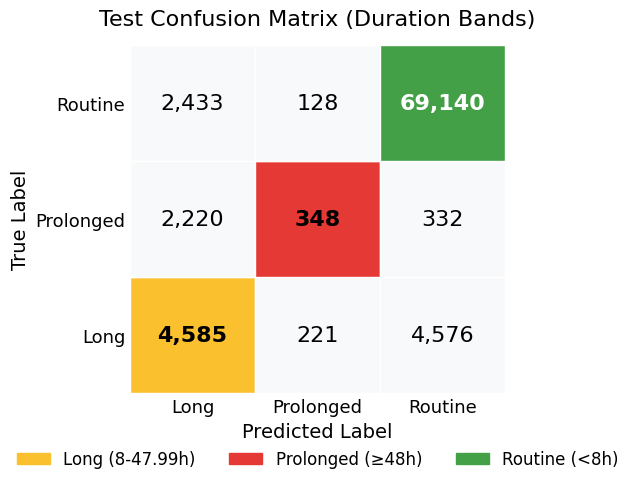

In [ ]:
from matplotlib.patches import Patch

# Generate classification report
print(classification_report(test_y_band, test_pred_band, target_names=le_band.classes_))

# Get confusion matrix
cm = confusion_matrix(test_y_band, test_pred_band, labels=le_band.transform(['Long', 'Prolonged', 'Routine']))

# Desired label order
desired_order = ['Long', 'Prolonged', 'Routine']
labels = desired_order

# Color map for each label
label_to_color = {
    'Long': '#fbc02d',        # Amber
    'Prolonged': '#e53935',   # Red
    'Routine': '#43a047',     # Green
}
off_diag = '#f8f9fa'

fig, ax = plt.subplots(figsize=(6, 5))
for i, true_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        color = label_to_color[true_label] if true_label == pred_label else off_diag
        text_color = 'white' if label_to_color[true_label] == '#43a047' and true_label == pred_label else 'black'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, ec='white'))
        ax.text(j+0.5, i+0.5, f"{cm[i, j]:,}", ha='center', va='center',
                fontsize=16, fontweight='bold' if i == j else 'normal',
                color=text_color)

ax.set_xticks(np.arange(len(labels)) + 0.5)
ax.set_yticks(np.arange(len(labels)) + 0.5)
ax.set_xticklabels(labels, fontsize=13)
ax.set_yticklabels(labels, fontsize=13, rotation=0)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_title('Test Confusion Matrix (Duration Bands)', fontsize=16, pad=14)

ax.tick_params(length=0)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlim(0, len(labels))
ax.set_ylim(0, len(labels))

legend_handles = [
    Patch(color='#fbc02d', label='Long (8-47.99h)'),
    Patch(color='#e53935', label='Prolonged (≥48h)'),
    Patch(color='#43a047', label='Routine (<8h)'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=3, frameon=False, fontsize=12)

plt.tight_layout()
plt.show()

> The colored diagonal highlights the number of cases for each class that were correctly identified by the model.


**Classification Report (Banding: Routine, Long, Prolonged)**

---
 **Routine outages (the majority)**:  Very high precision and recall. The model is highly accurate at identifying routine events.


**Long outages**: Moderate performance. Many long outages are misclassified, often as routine.


**Prolonged outages**:  
  - Low recall (0.12): Only 12% of true prolonged events are detected.
  - Low F1-score (0.19): Most prolonged events are missed or misclassified as routine or long.
  
**Confusion Matrix:**
- Many "long" and "prolonged" outages are misclassified as "routine."
- "Prolonged" class is heavily under-predicted.

---

###  **2.2 Error Analysis**

- Pinpoints why the models struggle with the upper tail (long outages).
- Helps decide whether better features, sampling, or hybrid approaches are needed.
----

In [ ]:
import warnings
from IPython.display import display, Markdown

# Suppress SettingWithCopyWarning for cleaner output
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Build DataFrame and filter for prolonged events (actual >= 48h)
test_results = pd.DataFrame({
    'actual_duration': y_true_test,
    'predicted_duration': y_pred_test
})
prolonged = test_results[test_results['actual_duration'] >= 48].copy()
prolonged['error'] = prolonged['predicted_duration'] - prolonged['actual_duration']

# Key error metrics
mean_err = prolonged['error'].mean()
median_err = prolonged['error'].median()
min_err = prolonged['error'].min()
max_err = prolonged['error'].max()

# Display error summary as a styled DataFrame
metrics = pd.DataFrame({
    'Mean error': [mean_err],
    'Median error': [median_err],
    'Min error': [min_err],
    'Max error': [max_err]
}).T
metrics.columns = ['Error (hours)']
metrics = metrics.round(2)
display(Markdown(" **Prolonged Event Prediction Error Summary**"))
display(metrics.style.format("{:,.2f}").set_properties(**{'font-size': '16px', 'font-weight': 'bold'}))

 **Prolonged Event Prediction Error Summary**

,Error (hours)
Mean error,-48.32
Median error,-41.89
Min error,-171.42
Max error,20.62


In [ ]:
# Display detailed describe table, rounded
describe_df = prolonged[['actual_duration', 'predicted_duration', 'error']].describe().T
describe_df = describe_df.round(2)
describe_df.index = ['Actual Duration', 'Predicted Duration', 'Error']
display(Markdown("**Detailed Statistics (Prolonged Events)**"))
display(
    describe_df.style
        .format("{:,.2f}")
        .set_properties(**{'font-size': '15px'})
)

**Detailed Statistics (Prolonged Events)**

,count,mean,std,min,25%,50%,75%,max
Actual Duration,"2,895.00",69.63,28.81,48.25,51.50,56.50,78.75,193.25
Predicted Duration,"2,895.00",21.30,12.13,3.59,11.14,18.39,29.94,78.50
Error,"2,895.00",-48.32,26.09,-171.42,-55.17,-41.89,-35.76,20.62


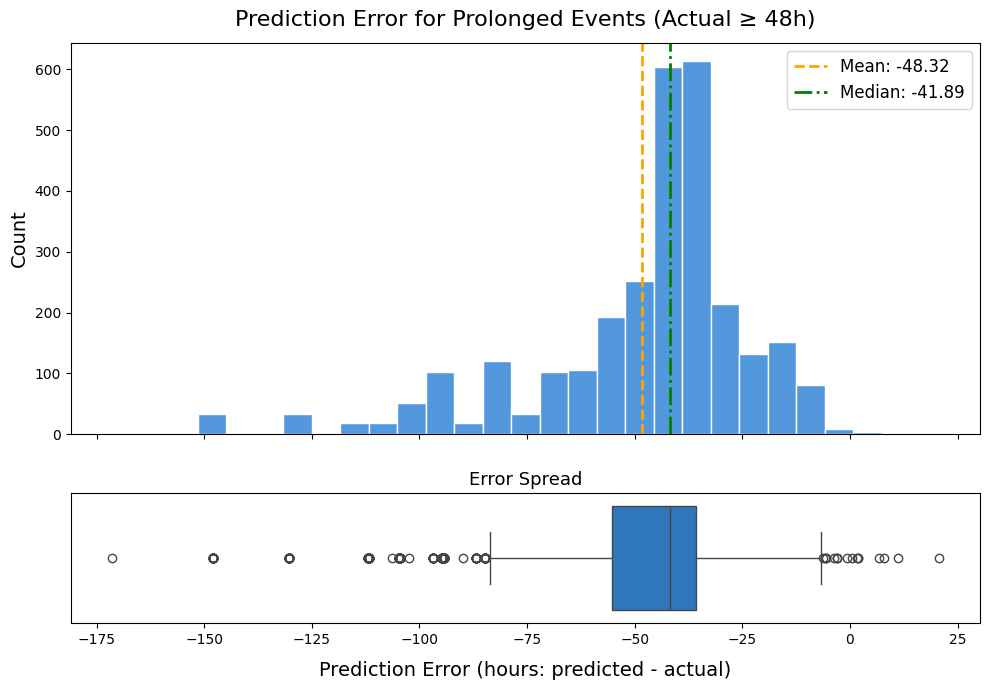

In [ ]:
# Plot error histogram with mean/median lines and boxplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Histogram
bins = np.linspace(prolonged['error'].min(), prolonged['error'].max(), 30)
sns.histplot(prolonged['error'], bins=bins, kde=False, ax=ax1, color='#1976d2', edgecolor='white')
ax1.axvline(mean_err, color='orange', linestyle='--', linewidth=2, label=f"Mean: {mean_err:.2f}")
ax1.axvline(median_err, color='green', linestyle='-.', linewidth=2, label=f"Median: {median_err:.2f}")
ax1.legend(fontsize=12)
ax1.set_title('Prediction Error for Prolonged Events (Actual ≥ 48h)', fontsize=16, pad=12)
ax1.set_ylabel('Count', fontsize=14)

# Boxplot
sns.boxplot(x=prolonged['error'], ax=ax2, color='#1976d2')
ax2.set_xlabel('Prediction Error (hours: predicted - actual)', fontsize=14, labelpad=10)
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_title('Error Spread', fontsize=13)

plt.tight_layout(h_pad=2)
plt.show()

- **Distribution:**  
  - Most predicted durations for prolonged events are well below the actual values.
  - Some extreme under-predictions (errors as large as -170 hours).
  - 75% of errors are less than -35.8 hours.
  - Only a tiny fraction of predictions are close to or above the actual duration.
  - Most errors are large and negative, confirming systematic underestimation for the longest outages.

---

- **Business impact:**
  - The goal is to flag or plan for the rare but critical long events, the model in its current form needs to improve for this purpose.


---

- **Next Steps**

  - Class Imbalance: Try techniques like class weighting, oversampling, or focal loss in  classifier to focus more on rare classes.
  - Hybrid Models: Consider a two-stage approach, first predict if an event is likely to be prolonged (classification), then predict the duration (regression) only for those.

---



### **2.3 Model Optimisation: Rare, Long/Prolonged Outage Prediction**


**Problem Statement:**  
- The model was highly accurate for “routine” (short) outages less than 8 hours, but performed poorly at identifying rare, high-impact “long” and “prolonged” outages.
- Business risk: Failing to escalate/anticipate rare but impactful events.

**Focus:**  
- Shifted to “rare event modeling”: maximising recall and detection of long/prolonged outages, while still maintaining strong performance on routine outages.

---

#### **Approach and Solution**

#### A. Class Redefinition & Banding
- Simplify the target into a binary classification:  
  - “Routine” (<8 hours)  
  - “Long+Prolonged” (≥8 hours)
- Use this banding for all classifier training and evaluation.


#### B. Class Imbalance Handling
- Oversampling: Use SMOTE to balance the training set so the rare class (“Long+Prolonged”) is better represented.
- Class Weights: Apply a higher class weight (e.g., 5x) to “Long+Prolonged” in the classifier’s loss function to make errors on rare events costlier to the model.


#### C. Modeling Approach (Hybrid Two-Stage)
   Stage 1: Binary Classification
   - Train a LightGBM classifier to predict if an outage is “Routine” or “Long+Prolonged”.
   - Use class balancing and custom loss weights.
   - Tune the probability threshold to prioritise recall for the rare class.

   
   Stage 2: Regression for Duration (Conditional)
   - For events classified as “Long+Prolonged”, run a regression model (LightGBMRegressor) to estimate the numeric duration.
   - Post-process regression output to further split “Long” vs. “Prolonged” (e.g., threshold at 48 hours).

#### D. Evaluation & Metrics
- Report per-class precision, recall, and F1 for both “Routine” and “Long+Prolonged”.
- Use confusion matrix to show tradeoffs.
- Assess regression MAE specifically on long/prolonged subset.


---



#### **2.3.1 Binary Banding: Routine vs. Long+Prolonged**




In [ ]:
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Redefine banding for binary classification: "Routine" vs "Long+Prolonged"
def band_duration_binary(hours):
    if hours >= 8:
        return 'Long+Prolonged'  # All events >=8 hours are grouped
    else:
        return 'Routine'

# Apply new banding to data
train_df['duration_band_2tier'] = train_df['duration'].apply(band_duration_binary)
val_df['duration_band_2tier'] = val_df['duration'].apply(band_duration_binary)
test_df['duration_band_2tier'] = test_df['duration'].apply(band_duration_binary)

# Label encode the target
le_band_2tier = LabelEncoder()
train_y_2tier = le_band_2tier.fit_transform(train_df['duration_band_2tier'])
val_y_2tier = le_band_2tier.transform(val_df['duration_band_2tier'])
test_y_2tier = le_band_2tier.transform(test_df['duration_band_2tier'])

# Use previous features
X_train_cls = train_df[features]
X_val_cls = val_df[features]
X_test_cls = test_df[features]

# Train a binary classifier
clf = LGBMClassifier(random_state=42, verbosity=-1)
clf.fit(X_train_cls, train_y_2tier)

# Predict and evaluate
test_pred_2tier = clf.predict(X_test_cls)
cm_2tier = confusion_matrix(test_y_2tier, test_pred_2tier)

# Generate the binary classification report as a DataFrame
report_dict_2tier = classification_report(
    test_y_2tier,
    test_pred_2tier,
    target_names=le_band_2tier.classes_,
    output_dict=True,
    digits=3
)
report_df_2tier = pd.DataFrame(report_dict_2tier).transpose()

# Display the classification report
print("\nClassification Report (2-Tier):\n")
print(report_df_2tier.round(3).to_string())

# Display the confusion matrix with labeled axes
print("\nConfusion Matrix (2-Tier):")
cm_df_2tier = pd.DataFrame(
    cm_2tier,
    index=[f"Actual: {cls}" for cls in le_band_2tier.classes_],
    columns=[f"Predicted: {cls}" for cls in le_band_2tier.classes_]
)
print(cm_df_2tier)


Classification Report (2-Tier):

                precision  recall  f1-score    support
Long+Prolonged      0.732   0.613     0.667  12282.000
Routine             0.936   0.962     0.948  71701.000
accuracy            0.911   0.911     0.911      0.911
macro avg           0.834   0.787     0.808  83983.000
weighted avg        0.906   0.911     0.907  83983.000

Confusion Matrix (2-Tier):
                        Predicted: Long+Prolonged  Predicted: Routine
Actual: Long+Prolonged                       7532                4750
Actual: Routine                              2759               68942


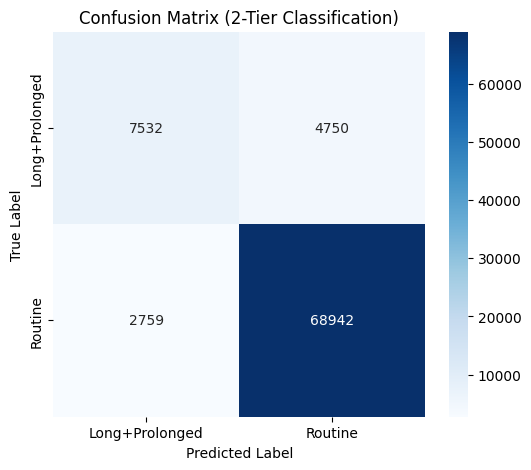

In [ ]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_2tier,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le_band_2tier.classes_,
    yticklabels=le_band_2tier.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (2-Tier Classification)')
plt.show()


* The model demonstrates strong overall accuracy (91%), with high precision and recall for routine outages, but moderate recall (61%) for the rarer, high-impact Long+Prolonged outages. Next, the hybrid approach will be applied to further optimise detection of long/prolonged outages and better support operational resilience.

----




#### **2.3.2 Hybrid Two-Stage Model with Imbalance Handling**

In [ ]:
# Two-stage modeling pipeline (simple, pragmatic)
# Binary classifier (Routine=0 vs Long+Prolonged=1) with SMOTE
# Regressor on log(duration) for cases predicted as Long+Prolonged
# Reports PR AUC (validation & test), classification metrics, confusion matrix

from lightgbm import LGBMClassifier, LGBMRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    average_precision_score
)

RANDOM_STATE = 42
CUSTOM_THRESHOLD = 0.64  # Keep it simple. Tune this on validation if needed.

# Prepare X/y for classifier (Routine vs Long+Prolonged)
def get_X_y_for_classifier(df: pd.DataFrame):
    X = df[features]
    y = (df['duration_band'] != 'Routine').astype(int)  # 1 if Long/Prolonged
    return X, y

# Prepare X/y for regressor (log-duration)
def get_X_y_for_regression(df: pd.DataFrame):
    X = df[features]
    y_log = np.log1p(df['duration'].astype(float))
    return X, y_log

X_train_clf, y_train_clf = get_X_y_for_classifier(train_df)
X_val_clf,   y_val_clf   = get_X_y_for_classifier(val_df)
X_test_clf,  y_test_clf  = get_X_y_for_classifier(test_df)

X_train_reg, y_train_reg_log = get_X_y_for_regression(train_df)
X_val_reg,   y_val_reg_log   = get_X_y_for_regression(val_df)
X_test_reg,  y_test_reg_log  = get_X_y_for_regression(test_df)

# Handle imbalance and train classifier
sm = SMOTE(random_state=RANDOM_STATE)
X_train_clf_bal, y_train_clf_bal = sm.fit_resample(X_train_clf, y_train_clf)

clf = LGBMClassifier(
    random_state=RANDOM_STATE,
    n_estimators=400,
    learning_rate=0.05,
    class_weight={0: 1, 1: 5}
)
clf.fit(X_train_clf_bal, y_train_clf_bal)

# Train regressor (log target)
regressor = LGBMRegressor(
    random_state=RANDOM_STATE,
    n_estimators=600,
    learning_rate=0.05
)
regressor.fit(X_train_reg, y_train_reg_log)

# Validation/Test PR AUC and classification metrics at fixed threshold
y_val_probs  = clf.predict_proba(X_val_clf)[:, 1]
y_test_probs = clf.predict_proba(X_test_clf)[:, 1]

ap_val  = average_precision_score(y_val_clf, y_val_probs)
ap_test = average_precision_score(y_test_clf, y_test_probs)
print(f"PR AUC (Average Precision) — Validation: {ap_val:.4f} | Test: {ap_test:.4f}")

thr = float(CUSTOM_THRESHOLD)
y_test_pred = (y_test_probs >= thr).astype(int)

print(f"\nClassification threshold: {thr}")
print("Test Classification Report (Routine=0, Long+Prolonged=1):")
print(classification_report(y_test_clf, y_test_pred, target_names=["Routine", "Long+Prolonged"]))

cm = confusion_matrix(y_test_clf, y_test_pred, labels=[0, 1])  # rows=true: Routine, Long+Prolonged
print("Confusion Matrix [rows=true, cols=pred]:")
print(cm)

# Quick metrics and workload
p = precision_score(y_test_clf, y_test_pred, zero_division=0)
r = recall_score(y_test_clf, y_test_pred, zero_division=0)
f1 = f1_score(y_test_clf, y_test_pred, zero_division=0)
flagged = int((y_test_pred == 1).sum())
total = len(y_test_pred)
print(f"Test @thr={thr:.2f} — precision={p:.3f}, recall={r:.3f}, F1={f1:.3f}")
print(f"Flagged as Long+Prolonged: {flagged}/{total} ({100*flagged/total:.2f}%)")

# 4) Two-stage inference: run regression for predicted Long+Prolonged
test_df = test_df.copy()
test_df['pred_extended'] = y_test_pred            # 1 if predicted Long+Prolonged
test_df['binary_pred'] = test_df['pred_extended'] # alias to avoid KeyErrors elsewhere

extended_mask = test_df['pred_extended'] == 1
X_test_extended = X_test_clf.loc[extended_mask]

# Predict durations for extended cases and invert the log transform
y_test_extended_pred_log = regressor.predict(X_test_extended)
y_test_extended_pred = np.expm1(y_test_extended_pred_log)

# Attach predictions back to test_df (NaN for Routine predictions)
test_df['pred_duration_extended_hours'] = np.nan
test_df.loc[extended_mask, 'pred_duration_extended_hours'] = y_test_extended_pred

# Simple final duration: fill routine predictions with a baseline
routine_baseline = float(np.median(train_df.loc[train_df['duration_band'] == 'Routine', 'duration']))
test_df['pred_duration_final_hours'] = np.where(
    test_df['pred_extended'] == 1,
    test_df['pred_duration_extended_hours'],
    routine_baseline
)

print("\nPredicted Long+Prolonged on test:", int(extended_mask.sum()), f"/ {len(test_df)} "
      f"({100*extended_mask.mean():.2f}%)")
print(f"Routine baseline duration used for non-extended: {routine_baseline:.2f} hours")

PR AUC (Average Precision) — Validation: 0.8512 | Test: 0.7592

Classification threshold: 0.64
Test Classification Report (Routine=0, Long+Prolonged=1):
                precision    recall  f1-score   support

       Routine       0.98      0.86      0.92     71701
Long+Prolonged       0.52      0.88      0.66     12282

      accuracy                           0.86     83983
     macro avg       0.75      0.87      0.79     83983
  weighted avg       0.91      0.86      0.88     83983

Confusion Matrix [rows=true, cols=pred]:
[[61764  9937]
 [ 1433 10849]]
Test @thr=0.64 — precision=0.522, recall=0.883, F1=0.656
Flagged as Long+Prolonged: 20786/83983 (24.75%)

Predicted Long+Prolonged on test: 20786 / 83983 (24.75%)
Routine baseline duration used for non-extended: 1.00 hours


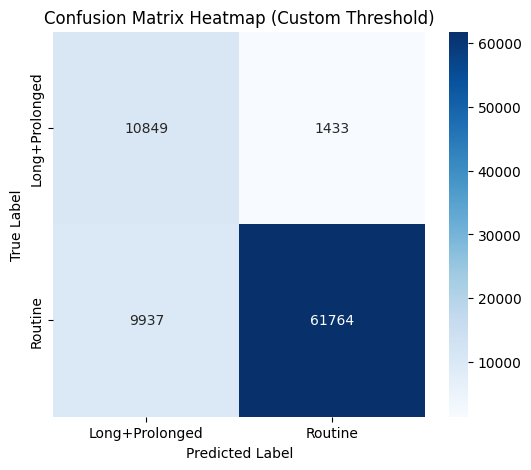

In [ ]:
# Compute confusion matrix for predictions
cm = confusion_matrix(y_test_clf, y_test_pred, labels=[1, 0])

# Class names in the order of labels used in confusion matrix
class_names = ["Long+Prolonged", "Routine"]

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap (Custom Threshold)')
plt.show()

In [ ]:
# MAE on cases your classifier flagged as Long/Prolonged (operational MAE)
extended_mask = test_df['pred_extended'] == 1

# Ensure index alignment with test_df
X_test_extended = X_test_clf.loc[extended_mask]

# Predict log-duration and invert
y_test_extended_pred_log = regressor.predict(X_test_extended)
y_test_extended_pred = np.expm1(y_test_extended_pred_log)

# True durations for those flagged cases
y_test_true_ext = test_df.loc[extended_mask, 'duration'].values

mae_ext = mean_absolute_error(y_test_true_ext, y_test_extended_pred)
print(f"MAE on predicted Long+Prolonged (operational): {mae_ext:.3f} hours")

# MAE on true Long/Prolonged cases (regression quality irrespective of classifier)
true_lp_mask = test_df['duration_band'].isin(['Long', 'Prolonged'])
X_test_true_lp = X_test_clf.loc[true_lp_mask]
y_pred_true_lp = np.expm1(regressor.predict(X_test_true_lp))
y_true_true_lp = test_df.loc[true_lp_mask, 'duration'].values

mae_true_lp = mean_absolute_error(y_true_true_lp, y_pred_true_lp)
print(f"MAE on TRUE Long+Prolonged (all positives): {mae_true_lp:.3f} hours")

# Simple baseline comparison for Long/Prolonged (median of train Long+Prolonged)
lp_train_mask = train_df['duration_band'].isin(['Long', 'Prolonged'])
lp_baseline = float(train_df.loc[lp_train_mask, 'duration'].median())

mae_baseline_lp = mean_absolute_error(y_true_true_lp, np.full_like(y_true_true_lp, lp_baseline, dtype=float))
print(f"Baseline MAE on TRUE Long+Prolonged (train median={lp_baseline:.2f} h): {mae_baseline_lp:.3f} hours")

MAE on predicted Long+Prolonged (operational): 13.145 hours
MAE on TRUE Long+Prolonged (all positives): 20.784 hours
Baseline MAE on TRUE Long+Prolonged (train median=18.50 h): 19.185 hours


----

**Hybrid Model Performance at Threshold 0.64**

- PR AUC (Average Precision): Validation = 0.8512 | Test = 0.7592
- Flagged workload: 20,786 of 83,983 events (24.75%) predicted as Long+Prolonged

---

**Classification Metrics**

| Class             | Precision | Recall | F1-score | Support |
|-------------------|-----------|--------|----------|---------|
| Routine           | 0.98      | 0.86   | 0.92     | 71,701  |
| Long+Prolonged    | 0.52      | 0.88   | 0.66     | 12,282  |
| Accuracy      |           |        | 0.86     | 83,983  |

---
**Confusion Matrix:**

|                        | Predicted Long+Prolonged | Predicted Routine |
|------------------------|---------------------------|-------------------|
| **Actual Long+Prolonged** | 10,849                    | 1,433             |
| **Actual Routine**        | 9,937                     | 61,764            |

- TP=10,849, FP=9,937, FN=1,433, TN=61,764

---

**Duration Regression (Stage 2)**

- Operational MAE (predicted-extended only): 13.145 hours
- MAE on TRUE Long+Prolonged: 20.784 hours
- Baseline MAE (train median on TRUE Long+Prolonged): 19.185 hours

> Note: The operational MAE is lower because it includes false positives (typically short events). On the true extended class, the current regressor is slightly worse than the simple baseline; most error comes from Prolonged cases.
---

**Business Interpretation**

A. Long+Prolonged (critical events)
- Recall ≈ 0.88: ~88% of critical outages are detected and escalated.
- Precision ≈ 0.52: About half of escalations are true critical events—an acceptable trade-off in a safety-critical context.
- Impact: High recall substantially reduces the risk of missing critical incidents; false positives add review workload but are manageable.

B. Routine outages
- Recall ≈ 0.86: Most routine events are correctly classified.
- ~14% of routine events are escalated (FP): Acceptable given the priority to capture critical events; contributes to the 24.75% overall flagged workload.
- Precision for “Routine” ≈ 0.98: Routine predictions are highly reliable.

C. False positives/negatives
- False Positives: 9,937
- False Negatives: 1,433
- Operational stance: Prefer manageable FPs over missed critical events (low FNs), aligned with safety and compliance goals.
---

**Business Value**

- Risk reduction: High recall on critical outages supports regulatory and safety objectives.
- Operational control: Flagged volume (~25%) is visible and manageable; enables proactive review/escalation.
- Strong Routine precision (0.98) and clear performance reporting support internal and external stakeholders.

---

**Implementation Notes and Stewardship**

- Threshold: Fixed at 0.64 (chosen on validation). Review monthly; re-tune only if recall falls below 0.88 or flagged rate drifts ±5 percentage points.
- KPIs to monitor: Recall, precision, flagged %, and base rate (prevalence).
- Regression: Keep as-is for operational guidance. If duration accuracy on Prolonged becomes a requirement, consider a small uplift (e.g., +10–20% when high risk of Prolonged) or a dedicated Prolonged specialist later.

---


## **3. Power Outage Severity Prediction: Customers Impact**

###  **Purpose**
Build a machine learning model to predict the severity of power outages, specifically, the number of customers affected (`max_customers`) for each outage event. Historical and contextual data are used to estimate severity, restoration time, and risk bands based on event features. This is formulated as a regression problem.


###  **Approach**

- **Supervised Regression:**  
  Use regression to predict a continuous value (customers affected).
- **Features:**  
  Include event time, geography, event type, lagged event counts, and other context available before the outage is resolved.
- **Data Splitting:**  
   Data is split into training, validation, and test sets, using time-based splits (to simulate real-world forecasting).

###  **Model**

- **Model Used:**  
  XGBoost Regressor (a popular, high-performing machine learning model for tabular data).
- **Calibration:**  
  Predictions are further calibrated using isotonic regression, making the predicted values more closely match true values (especially important for risk bands).

###  **Risk Banding**

After predicting the number of affected customers,  assign each event to a risk band (Critical, Monitor, Routine, Unflagged), based on where its predicted severity falls compared to all events (using quantiles).

- **Critical:**  
  Represents the largest and most severe outages. Immediate action required.

- **Monitor:**  
  Moderate-to-large outages, flagged for attention. Resource planning and continued monitoring.

- **Routine:**  
  Smaller outages; predicted values closely match actuals.

- **Unflagged:** Handle as business-as-usual.

---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from xgboost import XGBRegressor
from IPython.display import Markdown, display

# Data Preparation

# Ensure date parsing
df_model['start_time'] = pd.to_datetime(df_model['start_time'], errors='coerce')

# Target: severity of outage (here, max_customers)
target_col = 'max_customers'

# Define temporal splits based on start_time
train_cutoff = pd.Timestamp("2022-05-01")
val_cutoff = pd.Timestamp("2022-12-01")

train_df = df_model[df_model['start_time'] < train_cutoff]
val_df = df_model[
    (df_model['start_time'] >= train_cutoff) &
    (df_model['start_time'] < val_cutoff)
]
test_df = df_model[df_model['start_time'] >= val_cutoff]

# Select Features (NO leakage from min/mean/max/log_mean/log_max/customer_impact_ratio)
feature_cols = [
    # Temporal
    'year', 'event_weekday', 'event_hour', 'is_weekend',

    # Geographic
    'state', 'county', 'region',

    # Event features
    'event_type_grouped', 'duration_bucket',

    # Outage history (lags)
    'lag8_event_count', 'lag8_max_customers',
    'lag24_event_count', 'lag24_max_customers',
    'within_8h_event', 'within_24h_event'
]

# Dummify Categorical Features
categorical = ['state', 'county', 'region', 'event_type_grouped', 'duration_bucket']
df_model_dummies = pd.get_dummies(df_model[feature_cols], columns=categorical, drop_first=True)

X = df_model_dummies
y = df_model[target_col]

X_train = X.loc[train_df.index]
y_train = y.loc[train_df.index]
X_val = X.loc[val_df.index]
y_val = y.loc[val_df.index]
X_test = X.loc[test_df.index]
y_test = y.loc[test_df.index]

# Train XGBoost Regressor
xgb_reg = XGBRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1
)
xgb_reg.fit(X_train, y_train)
val_pred = xgb_reg.predict(X_val)
test_pred = xgb_reg.predict(X_test)

# Performance Reporting
def display_regression_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    md = f"**{label}**  \nMAE: `{mae:.2f}` &nbsp;&nbsp; RMSE: `{rmse:.2f}` &nbsp;&nbsp; R²: `{r2:.3f}`"
    display(Markdown(md))

display_regression_metrics(y_val, val_pred, 'Validation')
display_regression_metrics(y_test, test_pred, 'Test')

# Risk Banding by Predicted Severity
test_df = test_df.copy()
test_df['pred_max_customers'] = test_pred

# Band thresholds (adjust quantiles as needed)
critical_cut = test_df['pred_max_customers'].quantile(0.99)
monitor_cut = test_df['pred_max_customers'].quantile(0.95)
routine_cut = test_df['pred_max_customers'].quantile(0.80)

def severity_band(val):
    if val >= critical_cut:
        return "Critical"
    elif val >= monitor_cut:
        return "Monitor"
    elif val >= routine_cut:
        return "Routine"
    else:
        return "Unflagged"

test_df['severity_band'] = test_df['pred_max_customers'].apply(severity_band)

# Band summary & visualisation
severity_band_summary = (
    test_df.groupby('severity_band')
    .agg(
        count=('pred_max_customers', 'size'),
        actual_mean=('max_customers', 'mean'),
        predicted_mean=('pred_max_customers', 'mean')
    )
    .reindex(["Critical", "Monitor", "Routine", "Unflagged"])
)

severity_band_summary

**Validation**  
MAE: `1993.24` &nbsp;&nbsp; RMSE: `6480.56` &nbsp;&nbsp; R²: `0.874`

**Test**  
MAE: `1088.83` &nbsp;&nbsp; RMSE: `3729.48` &nbsp;&nbsp; R²: `0.687`

,count,actual_mean,predicted_mean
severity_band,,,
Critical,915,36017.738798,48282.929688
Monitor,3440,6815.882558,9321.134766
Routine,12442,2836.319724,2957.416260
Unflagged,67186,721.585047,825.491272


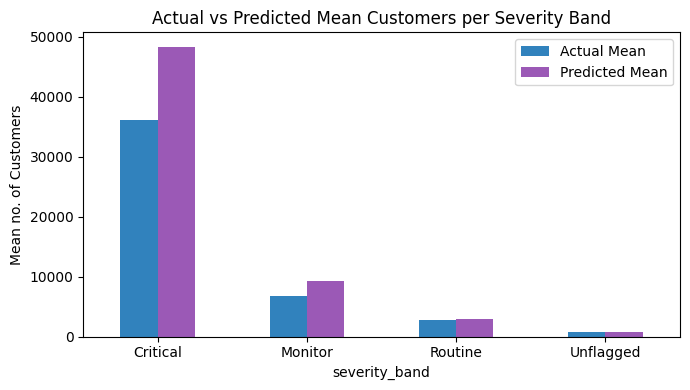

In [ ]:
# Mean actual and predicted customers per band

plt.figure(figsize=(7,4))
severity_band_summary[['actual_mean', 'predicted_mean']].plot(
    kind='bar',
    color=['#3182bd', '#9b59b6'],  # Blue for actual, purple for predicted
    ax=plt.gca()
)
plt.ylabel('Mean no. of Customers')
plt.title('Actual vs Predicted Mean Customers per Severity Band')
plt.xticks(rotation=0)
plt.legend(['Actual Mean', 'Predicted Mean'])
plt.tight_layout()
plt.show()

---
* Predicted Mean is higher than Actual Mean in every band, especially for Critical and Monitor.
* The difference is most pronounced in the Critical band (model tends to overpredict the mean impact for severe events).
* Explore calibration techniques to improve alignment between predicted and actual means. This will enhance model reliability and usefulness.
---

In [ ]:
# Model Calibration

from sklearn.isotonic import IsotonicRegression

# Fit XGBoost model as before and get validation predictions
xgb_reg.fit(X_train, y_train)
val_pred = xgb_reg.predict(X_val)
test_pred = xgb_reg.predict(X_test)

# Calibration: Fit isotonic regression on validation set
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_pred, y_val)  # Fit mapping from predicted to true

# Apply calibration to test predictions
test_pred_calib = iso.transform(test_pred)

# --- Evaluate calibrated predictions ---
display_regression_metrics(y_val, iso.transform(val_pred), 'Validation (Calibrated)')
display_regression_metrics(y_test, test_pred_calib, 'Test (Calibrated)')

# Use calibrated predictions for risk bands
test_df = test_df.copy()
test_df['pred_max_customers_calib'] = test_pred_calib

# Add the actual customers column to test_df
test_df['actual_customers'] = test_df['max_customers']

critical_cut = test_df['pred_max_customers_calib'].quantile(0.99)
monitor_cut = test_df['pred_max_customers_calib'].quantile(0.95)
routine_cut = test_df['pred_max_customers_calib'].quantile(0.80)

def severity_band(val):
    if val >= critical_cut:
        return "Critical"
    elif val >= monitor_cut:
        return "Monitor"
    elif val >= routine_cut:
        return "Routine"
    else:
        return "Unflagged"

test_df['severity_band'] = test_df['pred_max_customers_calib'].apply(severity_band)

severity_band_summary = test_df.groupby('severity_band').agg(
    count=('actual_customers', 'size'),
    actual_mean=('actual_customers', 'mean'),
    predicted_mean=('pred_max_customers_calib', 'mean')
).reset_index()

**Validation (Calibrated)**  
MAE: `1738.25` &nbsp;&nbsp; RMSE: `4908.61` &nbsp;&nbsp; R²: `0.928`

**Test (Calibrated)**  
MAE: `1091.10` &nbsp;&nbsp; RMSE: `3638.23` &nbsp;&nbsp; R²: `0.702`

In [ ]:
severity_band_summary

,severity_band,count,actual_mean,predicted_mean
0,Critical,1088,32572.326287,33036.625000
1,Monitor,4402,6212.251022,6394.123047
2,Routine,12865,2409.497007,2235.849121
3,Unflagged,65628,706.856388,812.054688


In [ ]:
# calibrated and uncalibrated result comparison

# Add predictions to test_df
test_df = test_df.copy()
test_df['pred_max_customers'] = test_pred
test_df['pred_max_customers_calib'] = test_pred_calib
test_df['actual_customers'] = y_test

# Define banding function --
def banding(preds):
    critical = pd.Series(preds).quantile(0.99)
    monitor = pd.Series(preds).quantile(0.95)
    routine = pd.Series(preds).quantile(0.80)
    def band(val):
        if val >= critical:
            return "Critical"
        elif val >= monitor:
            return "Monitor"
        elif val >= routine:
            return "Routine"
        else:
            return "Unflagged"
    return band

# Assign bands for uncalibrated predictions
test_df['severity_band_uncalib'] = test_df['pred_max_customers'].apply(banding(test_df['pred_max_customers']))

# Assign bands for calibrated predictions
test_df['severity_band_calib'] = test_df['pred_max_customers_calib'].apply(banding(test_df['pred_max_customers_calib']))

# Summary tables
def get_summary(df, band_col, pred_col):
    summary = df.groupby(band_col).agg(
        count=('actual_customers', 'size'),
        actual_mean=('actual_customers', 'mean'),
        predicted_mean=(pred_col, 'mean')
    ).reset_index()
    return summary

summary_uncalib = get_summary(test_df, 'severity_band_uncalib', 'pred_max_customers')
summary_calib = get_summary(test_df, 'severity_band_calib', 'pred_max_customers_calib')

print("Uncalibrated predictions summary:")
display(summary_uncalib)
print("\nCalibrated predictions summary:")
display(summary_calib)

Uncalibrated predictions summary:


,severity_band_uncalib,count,actual_mean,predicted_mean
0,Critical,915,36017.738798,48282.929688
1,Monitor,3440,6815.882558,9321.134766
2,Routine,12442,2836.319724,2957.416260
3,Unflagged,67186,721.585047,825.491272



Calibrated predictions summary:


,severity_band_calib,count,actual_mean,predicted_mean
0,Critical,1088,32572.326287,33036.625000
1,Monitor,4402,6212.251022,6394.123047
2,Routine,12865,2409.497007,2235.849121
3,Unflagged,65628,706.856388,812.054688


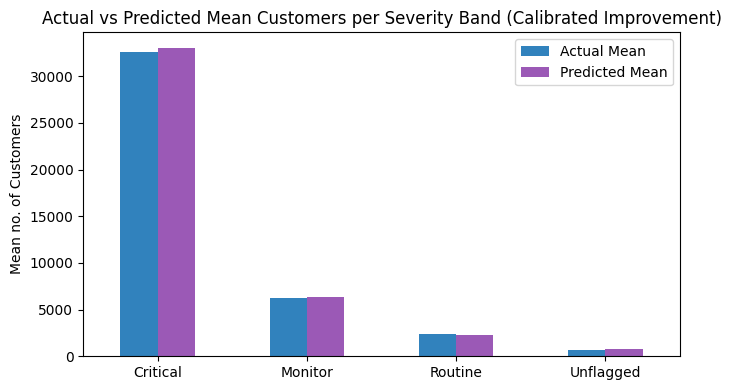

In [ ]:
# Calibrated Mean actual and predicted customers per band

severity_band_summary.index = ["Critical", "Monitor", "Routine", "Unflagged"]

plt.figure(figsize=(7,4))
severity_band_summary[['actual_mean', 'predicted_mean']].plot(
    kind='bar',
    color=['#3182bd', '#9b59b6'],
    ax=plt.gca()
)
plt.ylabel('Mean no. of Customers')
plt.title('Actual vs Predicted Mean Customers per Severity Band (Calibrated Improvement)')
plt.xticks(rotation=0)
plt.legend(['Actual Mean', 'Predicted Mean'])
plt.tight_layout()
plt.show()

---
* Actual Mean and Predicted Mean values are very close in all bands.
* Critical shows a strong match between actual and predicted means.
* The calibration process improved model accuracy, with predictions closely tracking actuals across all severity levels.
---

In [ ]:
# Band summary & impact stats using calibrated predictions

# Impact stats per severity band (same as before but with calibrated bands)
band_impact_calib = (
    test_df.groupby('severity_band')
    .agg(
        event_count=('pred_max_customers_calib', 'size'),
        total_customers=('max_customers', 'sum'),
        avg_customers=('max_customers', 'mean'),
        predicted_mean=('pred_max_customers_calib', 'mean')
    )
    .reindex(["Critical", "Monitor", "Routine", "Unflagged"])
    .reset_index()
)

# Calculate percentages
total_events = band_impact_calib['event_count'].sum()
total_customers = band_impact_calib['total_customers'].sum()

band_impact_calib['pct_of_events'] = band_impact_calib['event_count'] / total_events * 100
band_impact_calib['pct_of_impact'] = band_impact_calib['total_customers'] / total_customers * 100


display(Markdown("### Impact Stats per Severity Band (Calibrated, Test Set)"))

display(
    band_impact_calib[['severity_band', 'event_count', 'pct_of_events',
                       'total_customers', 'pct_of_impact', 'avg_customers', 'predicted_mean']]
    .style.format({
        'pct_of_events': '{:.2f}%',      # adds % sign
        'total_customers': '{:,.0f}',    # No decimals, thousands separator
        'pct_of_impact': '{:.2f}%',      # adds % sign
        'avg_customers': '{:,.0f}',      # No decimals
        'predicted_mean': '{:,.0f}'      # No decimals
    })
)

### Impact Stats per Severity Band (Calibrated, Test Set)

,severity_band,event_count,pct_of_events,total_customers,pct_of_impact,avg_customers,predicted_mean
0,Critical,1088,1.30%,"35,438,691",25.28%,"32,572","33,037"
1,Monitor,4402,5.24%,"27,346,329",19.51%,"6,212","6,394"
2,Routine,12865,15.32%,"30,998,179",22.11%,"2,409","2,236"
3,Unflagged,65628,78.14%,"46,389,571",33.09%,707,812


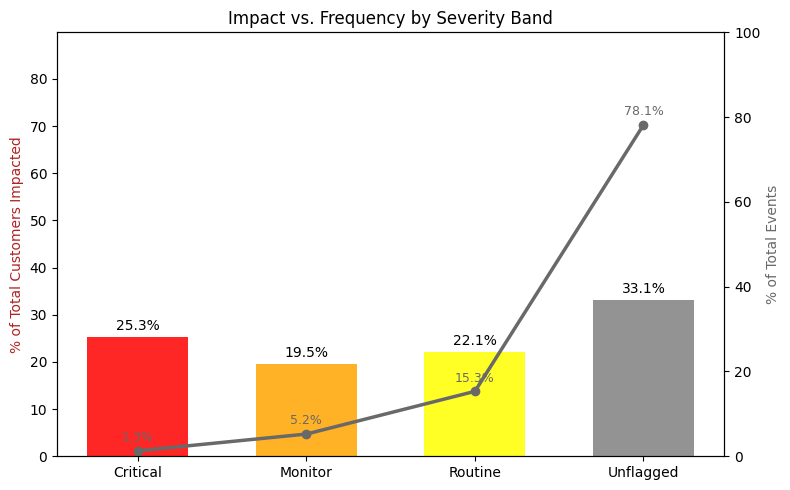

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualise Impact vs. Frequency by Severity Band
band_impact = band_impact_calib.copy()
colors = ['red', 'orange', 'yellow', 'grey']

fig, ax1 = plt.subplots(figsize=(8,5))

# Bar: % of Total Customers Impacted (distinct colors)
bars = ax1.bar(
    band_impact['severity_band'],
    band_impact['pct_of_impact'],
    color=colors,
    alpha=0.85,
    width=0.6
)
ax1.set_ylabel('% of Total Customers Impacted', color='firebrick')
ax1.set_ylim(0, max(band_impact['pct_of_impact'].max(), band_impact['pct_of_events'].max()) * 1.15)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0,3),
                 textcoords='offset points',
                 ha='center', va='bottom', fontsize=10)

# Line: % of Total Events
ax2 = ax1.twinx()
ax2.plot(
    band_impact['severity_band'],
    band_impact['pct_of_events'],
    color='dimgray',
    marker='o',
    linewidth=2.5,
    label='% of Total Events'
)
ax2.set_ylabel('% of Total Events', color='dimgray')
ax2.set_ylim(0, 100)

# Annotate line points
for idx, val in enumerate(band_impact['pct_of_events']):
    ax2.annotate(f'{val:.1f}%',
                 (band_impact['severity_band'][idx], val),
                 textcoords="offset points",
                 xytext=(0,7), ha='center', fontsize=9, color='dimgray')

plt.title('Impact vs. Frequency by Severity Band')
plt.tight_layout()
plt.show()

---
**Outage Severity Prediction - Operational Impact**

Risk & Event Distribution (Test Set)

| Band      | % Events | % Impact | Avg Customers |
|-----------|----------|----------|--------------|
| Critical  | 1.3%     | 25.3%    | 32,572       |
| Monitor   | 5.2%     | 19.5%    | 6,212        |
| Routine   | 15.3%    | 22.1%    | 2,409        |
| Unflagged | 78.1%    | 33.1%    |   707        |

---

Better Focus, Bigger Gains


* 1.3% of outages (Critical) cause 25% of all customer impact
* 6.5% of outages (Critical + Monitor) cause 45% of all customer impact
* Just 22% of events (Critical, Monitor, Routine) account for nearly 67% of all customers affected.
* The remaining 78% of events (Unflagged) account for only 33% of total customer impact.
---


* The calibrated ML model enables rapid triage: focus crews and comms on the tiny fraction of outages that truly matter.
* Resource efficiency: Drastically reduce “alarm fatigue” and operational sprawl.
* Confidence: Calibrated bands mean the right events get the right attention.

---



* Conclusion: “A small % of events = the majority of risk.”
---

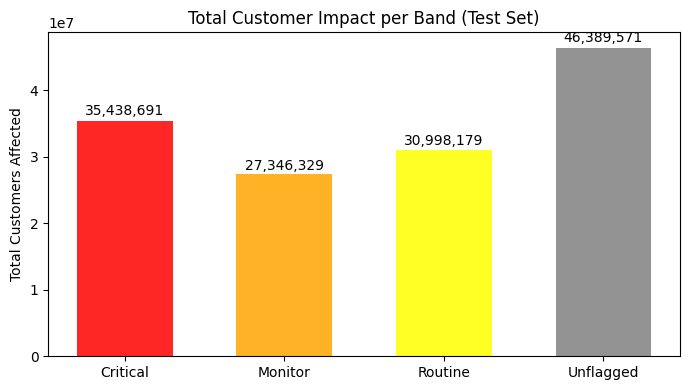

In [ ]:
# Total Customer Impact per Band

plt.figure(figsize=(7,4))
bars = plt.bar(
    band_impact['severity_band'],
    band_impact['total_customers'],
    color=colors,
    alpha=0.85,
    width=0.6
)
plt.ylabel('Total Customers Affected')
plt.title('Total Customer Impact per Band (Test Set)')
plt.tight_layout()

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.01*yval,
        f'{int(yval):,}',
        ha='center', va='bottom', fontsize=10
    )
plt.show()

In [ ]:
import pandas as pd
from IPython.display import display, Markdown

# Count of events per severity band and grouped event type
pivot_count = pd.pivot_table(
    test_df,
    values='actual_customers',
    index='event_type_grouped',
    columns='severity_band_calib',
    aggfunc='count',
    fill_value=0
)

# Mean predicted customers per severity band and grouped event type
pivot_pred_mean = pd.pivot_table(
    test_df,
    values='pred_max_customers_calib',
    index='event_type_grouped',
    columns='severity_band_calib',
    aggfunc='mean'
).round(0)

# Display the table: Event Count by Event Type (Grouped) and Calibrated Severity Band
display(Markdown("### Event Count by Event Type (Grouped) and Calibrated Severity Band"))
display(pivot_count.style.format('{:,.0f}'))

### Event Count by Event Type (Grouped) and Calibrated Severity Band

severity_band_calib,Critical,Monitor,Routine,Unflagged
event_type_grouped,,,,
attack,13,77,965,"6,450"
cyber,0,1,34,283
fuel,0,1,38,92
grid issue,8,82,604,"4,163"
other,6,50,642,"5,499"
unknown,0,2,26,342
weather,"1,061","4,189","10,556","48,799"


In [ ]:
# Display the table: Mean Predicted Customers by Event Type (Grouped) and Calibrated Severity Band

display(Markdown("### Mean Predicted Customers by Event Type (Grouped) and Calibrated Severity Band"))
display(pivot_pred_mean.style.format('{:,.0f}'))

### Mean Predicted Customers by Event Type (Grouped) and Calibrated Severity Band

severity_band_calib,Critical,Monitor,Routine,Unflagged
event_type_grouped,,,,
attack,"23,568","6,464","1,895",944
cyber,nan,"11,582","1,654",940
fuel,nan,"5,277","1,981","1,041"
grid issue,"65,013","7,420","2,052",888
other,"36,411","6,308","1,913",972
unknown,nan,"5,277","1,788",992
weather,"32,892","6,373","2,301",768


- Grid issues in the Critical band have the highest mean predicted customers (65,013) —much higher than weather or attack critical events.
- Weather Critical events, while numerous, have a lower mean impact per event than grid issue Criticals.
- For some event types (cyber, fuel, unknown), there are no Critical events, resulting in `NaN` (not a number) values for those categories.

**Operational Insight**
> While most Critical events are due to weather, grid issues—though rarer—have the highest average customer impact when they do occur.

**Resource Allocation**
- These findings suggest that grid issue Criticals should be prioritised for attention and resources, even though they are less frequent than weather-related events.
- Weather-related Critical events are more common, but typically have a lower impact per event.

---



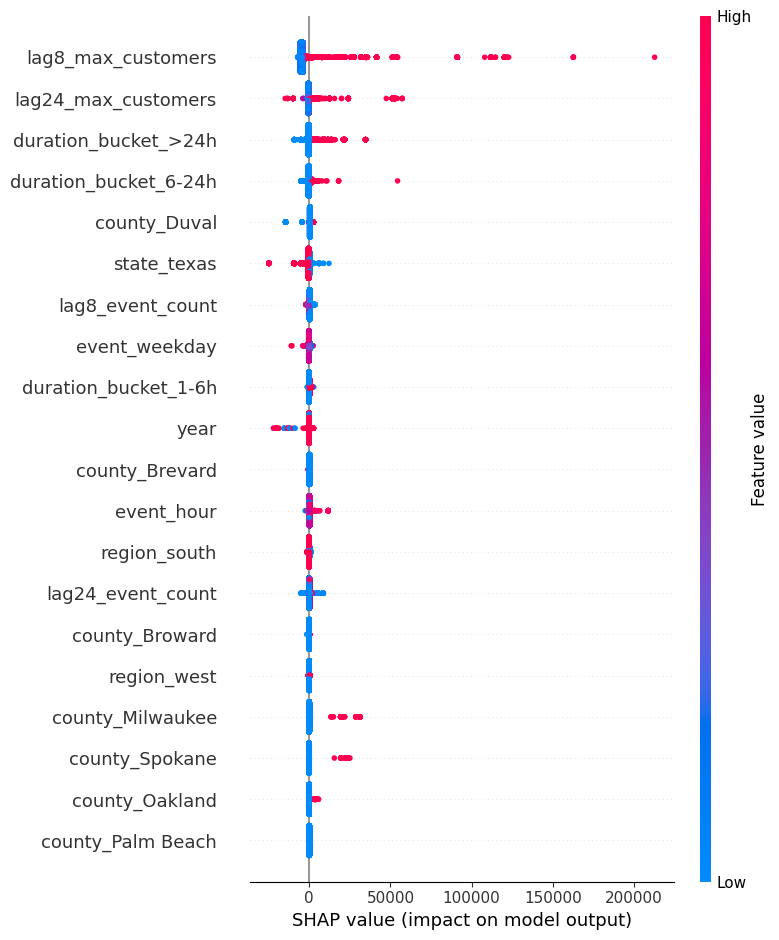

In [ ]:
# Plot Shap to explain Feature Importance

import shap
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*NumPy global RNG was seeded.*"
)

# Fit model (xgb_reg)
xgb_reg.fit(X_train, y_train)

# SHAP explainer for tree models (efficient for XGBoost)
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test)

# Local explanation for a single prediction (first row in test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

---
**Most Influential Features:**

* lag8_max_customers and lag24_max_customers (recent outage size): These have the largest impact on predicted severity, meaning recent large outages strongly increase the predicted number of customers affected.

* duration_bucket_>24h and duration_bucket_6-24h: Longer outage durations are also strong drivers of severity predictions.

* Counties: Several Florida counties—Duval, Brevard, Broward, Palm Beach—appear among the top 20 features, indicating that location-specific historical patterns in Florida are highly influential in predictions.

* State/Region: The presence of state_texas, region_south, and region_west suggests geographic factors also contribute.

**Feature Value Coloring:**

* High feature values (pink) for lagged max_customers and long duration buckets push predictions higher.

* For Florida counties, high feature values also lead to higher predicted outage severity.

---

## **4. Scenario-Based Outage Impact Simulation**

### **Purpose**
Enables “what if” analysis for grid planning and resilience, testing model responses to diverse or extreme hypothetical conditions (e.g., severe weather, grid issues, attacks), and quantifying operational risk and resource needs before events happen.

### **Modeling Approach**
- **Targeted Coverage:**  
  Historical outage data is analysed to identify states and event categories with the highest frequency and severity—including Texas, California, Michigan, and Florida, and event types such as weather, grid issues, attacks, fuel, and cyber incidents.

- **Theme–State Mapping:**  
  Simulations focus on high-impact combinations of event types and states, ensuring results are relevant for regions most at risk.

- **Predictive Modeling:**  
  For each scenario (theme–state), machine learning models (XGBoost, Random Forest) estimate:
    - **Customer Impact:** Maximum number of customers affected per event.
    - **Outage Duration:** Event duration, log-transformed and calibrated for improved accuracy.

- **Risk Banding:**  
  Predicted impacts and durations are stratified into operational risk bands (Critical, Monitor, Routine, Unflagged for customers; Long/Prolonged, Routine for durations) using empirical quantiles, supporting clear resource prioritization.

### **Uncertainty Quantification**
- **Bootstrap Analysis:**  
  Confidence intervals for mean and maximum predicted customers/durations are estimated via 1,000 bootstrap samples, quantifying scenario-level model uncertainty.
- **Monte Carlo Simulation:**  
  Additional uncertainty is assessed by repeating train/test splits and model runs across 1,000 Monte Carlo iterations, capturing variability due to data sampling and model fit.

### **Operational Applications**
- **Planning and Resilience:**  
  Scenario simulation informs emergency response, resource allocation, and grid resilience strategies.
- **Risk Communication:**  
  Quantified uncertainty and risk bands support transparent stakeholder engagement and actionable, data-driven decision-making.

---

In [ ]:
# Visualise Top outage events by state

import plotly.express as px

# Ensure state is lowercase
df_model['state'] = df_model['state'].str.lower()

# Count number of events per (state, grouped event type)
grouped_event_counts = (
    df_model.groupby(['state', 'event_type_grouped'])
    .size()
    .reset_index(name='Count')
)

# Sort by count descending and take top 30
top30_events = grouped_event_counts.sort_values(by='Count', ascending=False).head(30)

# Create a label for easier x-axis reading
top30_events['label'] = top30_events['state'].str.title() + ' - ' + top30_events['event_type_grouped'].str.title()

# Bar chart
fig = px.bar(
    top30_events,
    x='Count',
    y='label',
    color='event_type_grouped',
    orientation='h',
    title="<b>Top 30 Power Outage Events by State and Category</b>",
    color_discrete_map={
        'weather': '#1f77b4',
        'grid issue': '#ff7f0e',
        'fuel': '#2ca02c',
        'cyber': '#d62728',
        'attack': '#9467bd',
        'unknown': '#7f7f7f',
        'other': '#7f7f7f'
    },
)

# Improve layout
fig.update_layout(
    height=800,
    xaxis_title='Event Count',
    yaxis_title='State - Event Category',
    title_x=0.5,
    legend_title_text='Event Type Grouped',
    font=dict(size=14),
    yaxis={'categoryorder': 'total ascending'},
    margin=dict(l=150, r=30, t=60, b=30)
)

fig.show()

---
The chart ranks the top 30 power outage events by state and category, revealing that:

* **Texas** stands out as a hotspot for outage events, especially weather-related incidents, with a notably high event count. The significance of Texas is further underscored by the major grid outage of 2021, this makes it a critical focus for multiple themes, including weather, grid issues, and cyber/physical attacks.

* **California, Michigan, and Florida** also rank highly for outage frequency, but with a more diverse mix of underlying causes. For example, California is affected by weather (wildfires, storms), grid reliability challenges, and fuel supply disruptions, while Florida’s outages are primarily driven by hurricanes and tropical storms. Michigan’s prominence is due to recurrent severe weather events.

By targeting these states and event categories, the simulation ensures coverage of regions with the highest historical outage frequency and risk, supporting realistic scenario planning and resource allocation.

* **Weather**: Texas, Michigan, Florida, and California are included due to their high frequency and severity of weather-related outages.
* **Grid Issue**: Texas, California, and Florida are selected for their history of major grid infrastructure failures and reliability concerns.
* **Attack**: Texas and California are chosen for their exposure to physical and cyber attacks on critical grid assets.
* **Fuel**: California is included for its notable fuel supply constraints impacting power generation.
* **Cyber**: Texas is prioritised due to its large energy infrastructure and history of cyber incidents.
---



In [ ]:
# Theme–state-specific outage impact simulation to predict both customer impact and duration of outages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from xgboost import XGBRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

# Theme-State mapping
theme_state_map = {
    "weather": ["texas", "michigan", "florida", "california"],
    "grid issue": ["texas", "california", "florida"],
    "attack": ["texas", "california"],
    "fuel": ["california"],
    "cyber": ["texas"],
}

# Band color maps and order
CUSTOMER_BAND_COLORS = {
    "Critical": "#FF3333",
    "Monitor": "#FFB733",
    "Routine": "#FFFF33",
    "Unflagged": "#BEBEBE"
}
DURATION_BAND_COLORS = {
    "Long/Prolonged": "#FF3333",
    "Routine": "#BEBEBE"
}
CUSTOMER_ORDER = ["Critical", "Monitor", "Routine", "Unflagged"]
DURATION_ORDER = ["Long/Prolonged", "Routine"]

# Helper functions
def fit_regressor(X_train, y_train, method='xgb'):
    if method == 'xgb':
        model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
    elif method == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    else:
        raise ValueError("Unknown method")
    model.fit(X_train, y_train)
    return model

def fit_calibrator(preds, y_true):
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(preds, y_true)
    return iso

def assign_customer_band(val, cuts):
    critical_cut, monitor_cut, routine_cut = cuts
    if val >= critical_cut:
        return "Critical"
    elif val >= monitor_cut:
        return "Monitor"
    elif val >= routine_cut:
        return "Routine"
    else:
        return "Unflagged"

def assign_duration_band(val, threshold=8):
    return "Long/Prolonged" if val >= threshold else "Routine"

# Ensure duration_hours exists
df_model = df_model.copy()
df_model['duration_hours'] = df_model['duration']

In [ ]:
# Simulation loop and summary tables

simulation_results = []

for theme, states in theme_state_map.items():
    for state in states:
        # Section header
        display(Markdown(f"""
<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `{theme.upper()}` in `{state.upper()}`
<br>
"""))

        # Filter data
        df = df_model[
            (df_model['event_type_grouped'] == theme) &
            (df_model['state'] == state)
        ].copy()

        if len(df) < 50:
            print("  Skipping: not enough data.")
            continue

        # Drop missing target values
        cdf = df.dropna(subset=['max_customers', 'duration_hours']).copy()
        if len(cdf) < 50:
            print("  Skipping: not enough valid data after filtering.")
            continue

        # Features
        customer_features = [
            'year', 'event_weekday', 'event_hour', 'is_weekend',
            'state', 'county', 'region',
            'event_type_grouped', 'duration_bucket',
            'lag8_event_count', 'lag8_max_customers',
            'lag24_event_count', 'lag24_max_customers',
            'within_8h_event', 'within_24h_event'
        ]
        duration_features = [
            'year', 'event_weekday', 'event_hour', 'is_weekend',
            'state', 'county', 'region',
            'event_type_grouped',
            'lag8_event_count', 'lag8_max_customers',
            'lag24_event_count', 'lag24_max_customers',
            'within_8h_event', 'within_24h_event'
        ]

        # Train/test split
        train = cdf.sample(frac=0.7, random_state=42)
        test = cdf.drop(train.index)

        # Customer Model
        cat_cols_cust = ['state', 'county', 'region', 'event_type_grouped', 'duration_bucket']
        X_train_cust = pd.get_dummies(train[customer_features], columns=cat_cols_cust, drop_first=True)
        X_test_cust = pd.get_dummies(test[customer_features], columns=cat_cols_cust, drop_first=True)
        X_test_cust = X_test_cust.reindex(columns=X_train_cust.columns, fill_value=0)
        y_train_cust = train['max_customers']
        y_test_cust = test['max_customers']

        cust_model = fit_regressor(X_train_cust, y_train_cust, method='xgb')
        y_test_pred_cust = cust_model.predict(X_test_cust)
        iso_cust = fit_calibrator(y_test_pred_cust, y_test_cust)
        y_test_pred_cust_calib = iso_cust.transform(y_test_pred_cust)

        # Customer banding
        crit = np.quantile(y_test_pred_cust_calib, 0.99)
        mon = np.quantile(y_test_pred_cust_calib, 0.95)
        rou = np.quantile(y_test_pred_cust_calib, 0.80)
        cuts_cust = (crit, mon, rou)
        test = test.copy()
        test['pred_max_customers_calib'] = y_test_pred_cust_calib
        test['customer_band'] = test['pred_max_customers_calib'].apply(lambda x: assign_customer_band(x, cuts_cust))

        # Duration Model
        cat_cols_dur = ['state', 'county', 'region', 'event_type_grouped']
        train['log_duration'] = np.log1p(train['duration_hours'])
        test['log_duration'] = np.log1p(test['duration_hours'])
        X_train_dur = pd.get_dummies(train[duration_features], columns=cat_cols_dur, drop_first=True)
        X_test_dur = pd.get_dummies(test[duration_features], columns=cat_cols_dur, drop_first=True)
        X_test_dur = X_test_dur.reindex(columns=X_train_dur.columns, fill_value=0)
        y_train_dur = train['log_duration']
        y_test_dur = test['log_duration']

        dur_model = fit_regressor(X_train_dur, y_train_dur, method='xgb')
        y_test_pred_dur = dur_model.predict(X_test_dur)
        y_test_pred_dur_exp = np.expm1(y_test_pred_dur)
        test['pred_duration'] = y_test_pred_dur_exp
        test['duration_band'] = test['pred_duration'].apply(assign_duration_band)

        # Summaries
        cust_summary = test.groupby('customer_band')['pred_max_customers_calib'].agg(['count','mean','max']).reset_index()
        cust_summary['mean'] = cust_summary['mean'].round(0).astype(int)
        cust_summary['max'] = cust_summary['max'].round(0).astype(int)
        cust_summary['customer_band'] = pd.Categorical(cust_summary['customer_band'], categories=CUSTOMER_ORDER, ordered=True)
        cust_summary = cust_summary.sort_values('customer_band')

        dur_summary = test.groupby('duration_band')['pred_duration'].agg(['count','mean','max']).reset_index()
        dur_summary['mean'] = dur_summary['mean'].round(1)
        dur_summary['max'] = dur_summary['max'].round(1)
        dur_summary['duration_band'] = pd.Categorical(dur_summary['duration_band'], categories=DURATION_ORDER, ordered=True)
        dur_summary = dur_summary.sort_values('duration_band')

        # Display summaries (inside loop)
        display(Markdown("#### Customer Band Summary"))
        display(
            cust_summary.style
            .background_gradient(subset=['mean', 'max'], cmap='OrRd')
            .bar(subset=['count'], color='#FFA07A')
        )
        display(Markdown("#### Duration Band Summary"))
        display(
            dur_summary.style
            .background_gradient(subset=['mean', 'max'], cmap='YlGnBu')
            .bar(subset=['count'], color='#90EE90')
        )

        test['theme'] = theme
        test['state'] = state
        simulation_results.append(test)


<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `WEATHER` in `TEXAS`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,522,82922,455986
1,Monitor,1937,8671,22203
2,Routine,8603,2110,4793
3,Unflagged,37720,645,1313


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,3056,17.000000,80.199997
1,Routine,45726,1.900000,8.000000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `WEATHER` in `MICHIGAN`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,215,214449,265444
1,Monitor,946,49849,148553
2,Routine,3900,8401,24395
3,Unflagged,16150,1090,3666


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,4965,19.799999,68.800003
1,Routine,16246,3.000000,8.000000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `WEATHER` in `FLORIDA`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,112,1458072,1777800
1,Monitor,417,421031,1044000
2,Routine,1583,44334,204358
3,Unflagged,8018,892,2612


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,1353,25.900000,111.400002
1,Routine,8777,1.900000,8.000000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `WEATHER` in `CALIFORNIA`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,88,64638,122875
1,Monitor,362,27766,39552
2,Routine,1571,7291,15320
3,Unflagged,6678,1062,3037


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,263,13.400000,33.299999
1,Routine,8436,2.000000,8.000000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `GRID ISSUE` in `TEXAS`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,52,28168,305122
1,Monitor,365,2779,6280
2,Routine,530,1300,2410
3,Unflagged,3507,683,1117


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,41,14.000000,22.299999
1,Routine,4413,1.500000,7.800000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `GRID ISSUE` in `CALIFORNIA`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,46,52045,89427
1,Monitor,170,12340,24188
2,Routine,779,2646,7298
3,Unflagged,2763,903,1530


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,69,14.000000,22.600000
1,Routine,3689,2.100000,7.900000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `GRID ISSUE` in `FLORIDA`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,13,3418,3418
1,Monitor,50,2203,2907
2,Routine,104,1464,1686
3,Unflagged,622,997,1375


#### Duration Band Summary

,duration_band,count,mean,max
0,Routine,789,1.200000,4.600000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `ATTACK` in `TEXAS`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,39,6899,28904
1,Monitor,132,2069,4024
2,Routine,416,1143,1233
3,Unflagged,1745,675,1029


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,10,11.700000,15.900000
1,Routine,2322,1.400000,8.000000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `ATTACK` in `CALIFORNIA`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,37,17195,73183
1,Monitor,173,4388,8080
2,Routine,1290,1595,2795
3,Unflagged,2104,889,1246


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,26,11.300000,23.400000
1,Routine,3578,2.300000,7.800000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `FUEL` in `CALIFORNIA`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,10,44713,104079
1,Monitor,33,10058,27484
2,Routine,124,3272,4152
3,Unflagged,651,1011,2368


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,14,13.100000,25.900000
1,Routine,804,2.200000,7.800000



<br><hr style="border-top: 2px solid #bbb"><br>
### Simulating: `CYBER` in `TEXAS`
<br>


#### Customer Band Summary

,customer_band,count,mean,max
0,Critical,15,24285,305122
1,Monitor,12,2291,2291
2,Routine,62,1522,1761
3,Unflagged,351,552,860


#### Duration Band Summary

,duration_band,count,mean,max
0,Long/Prolonged,6,10.800000,14.700000
1,Routine,434,1.600000,6.800000


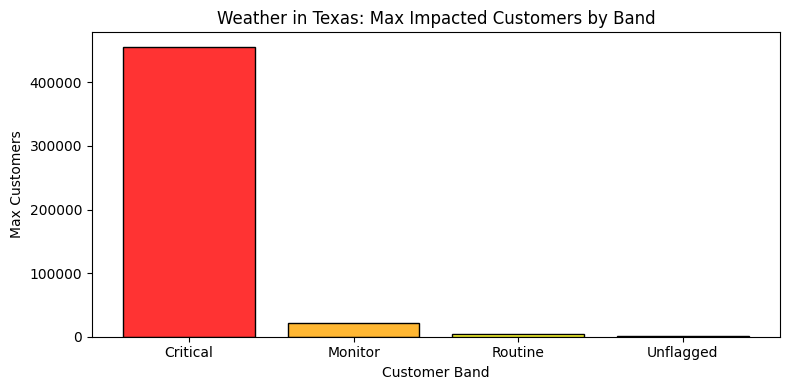

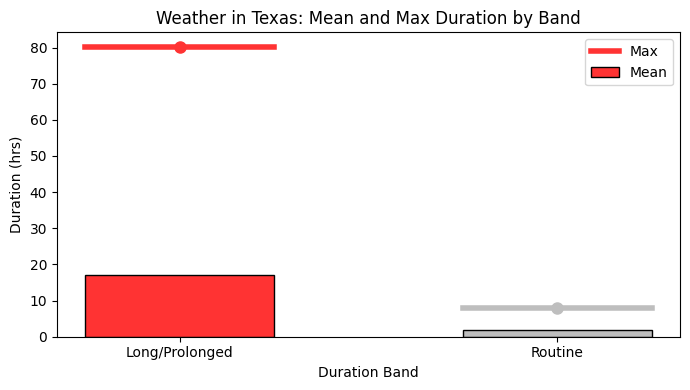

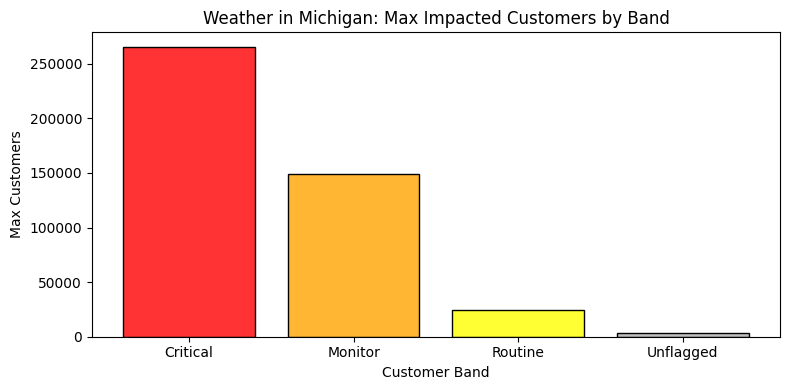

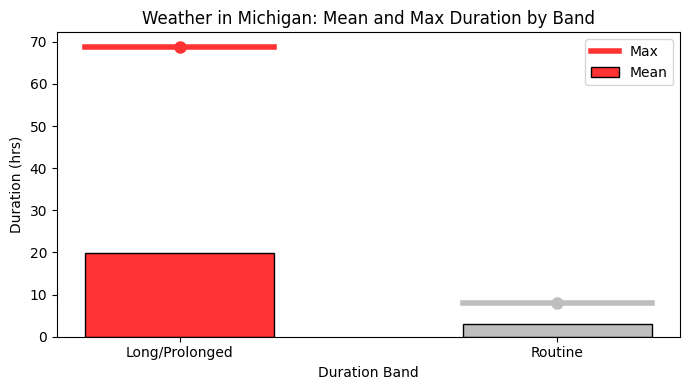

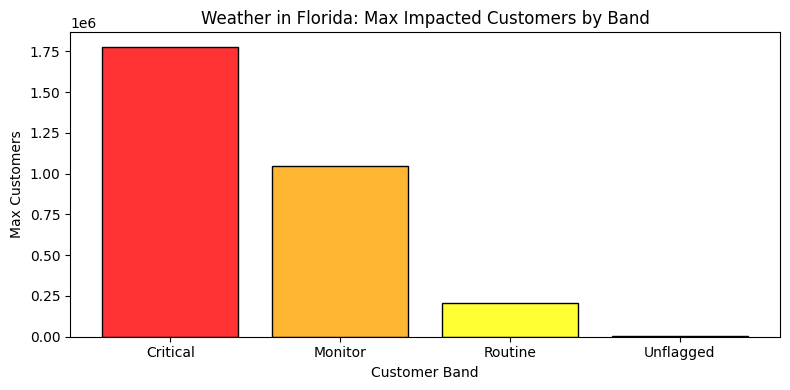

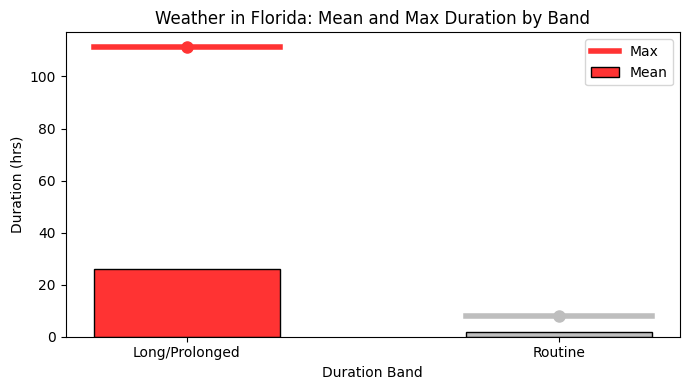

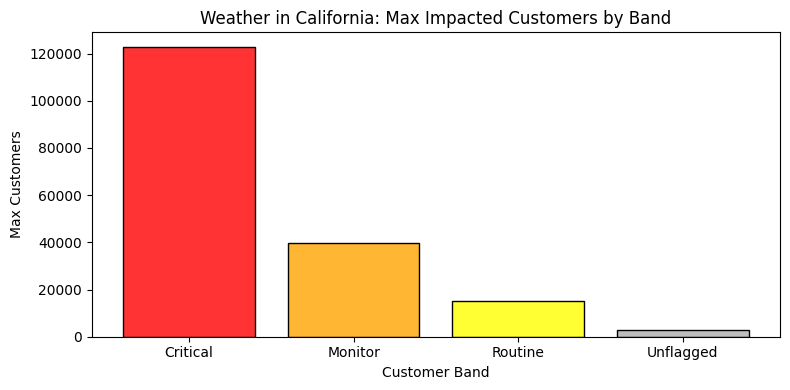

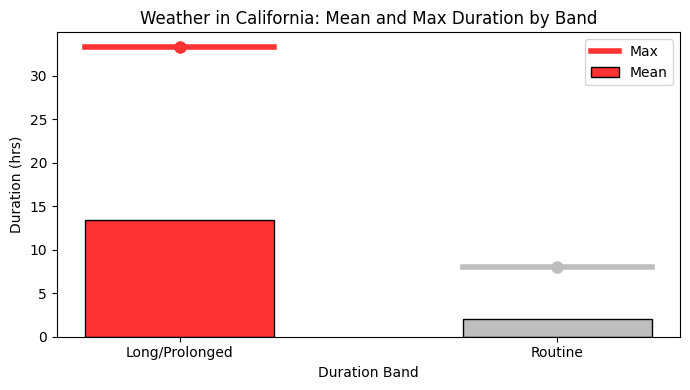

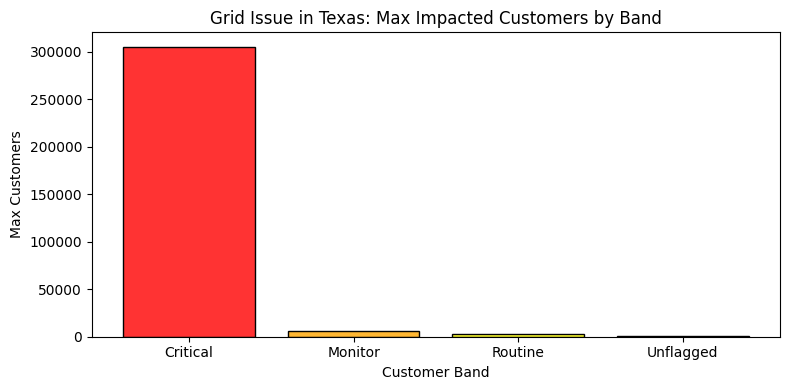

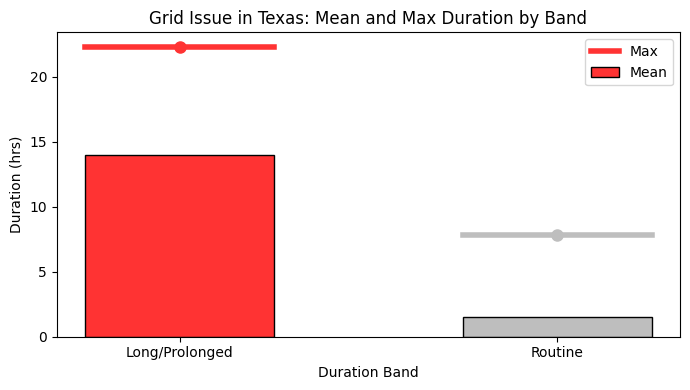

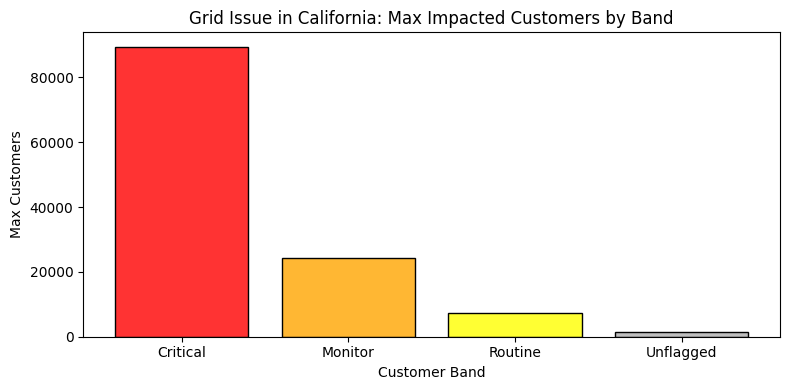

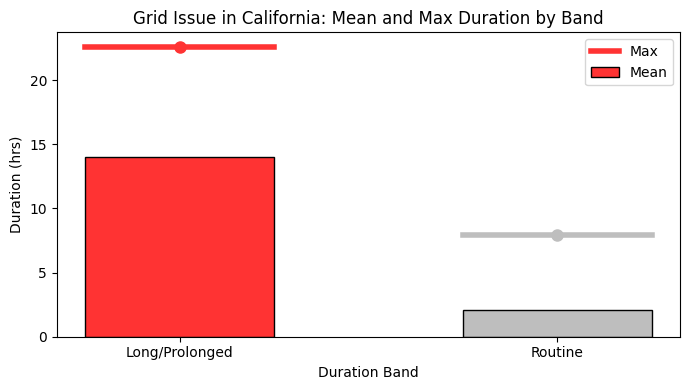

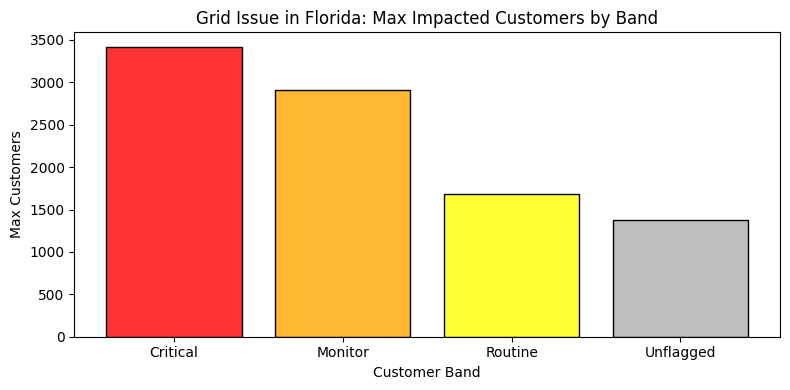

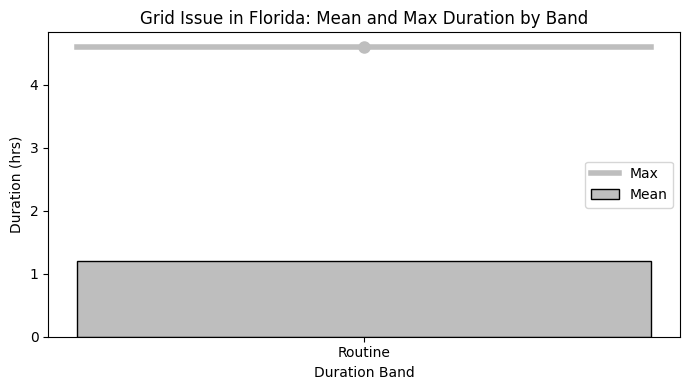

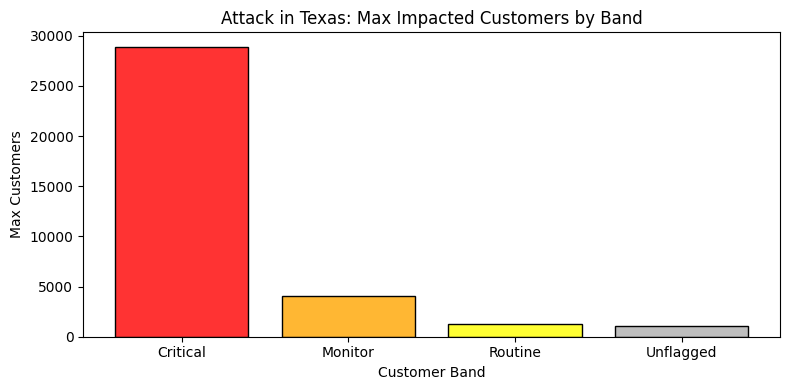

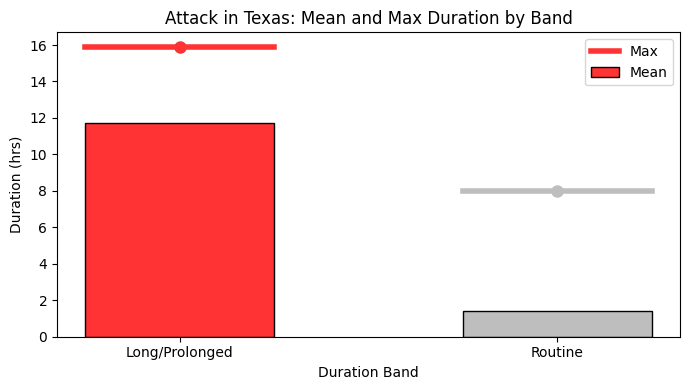

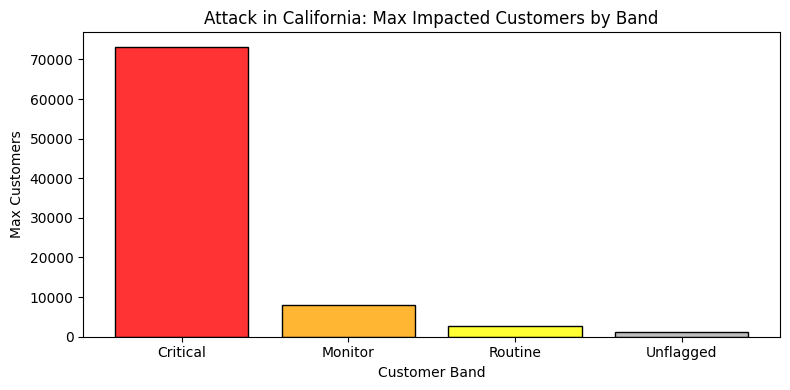

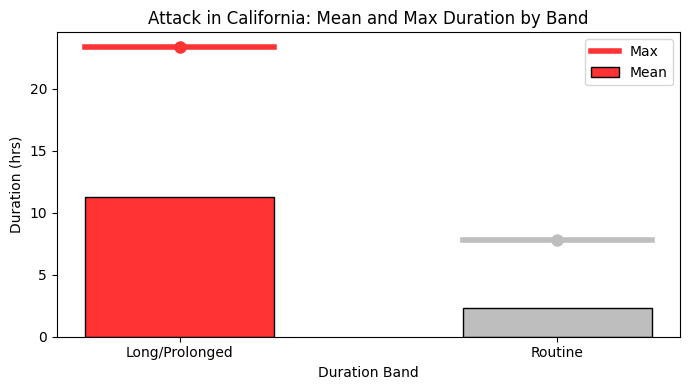

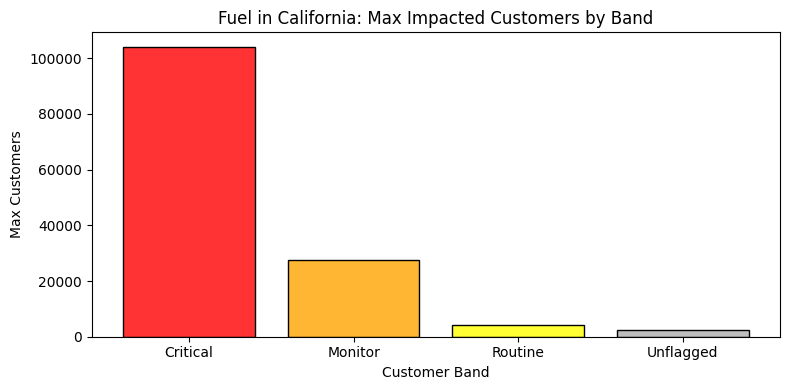

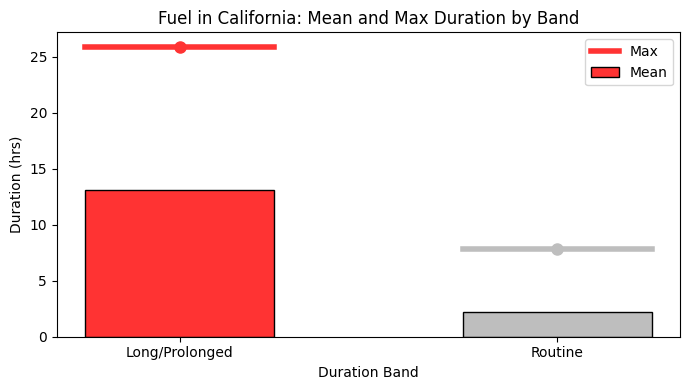

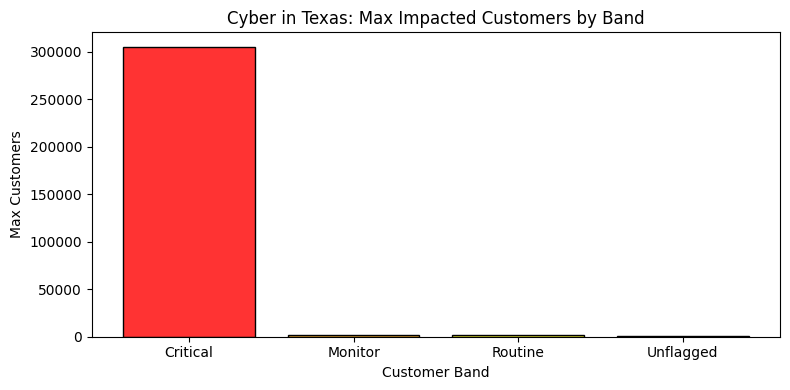

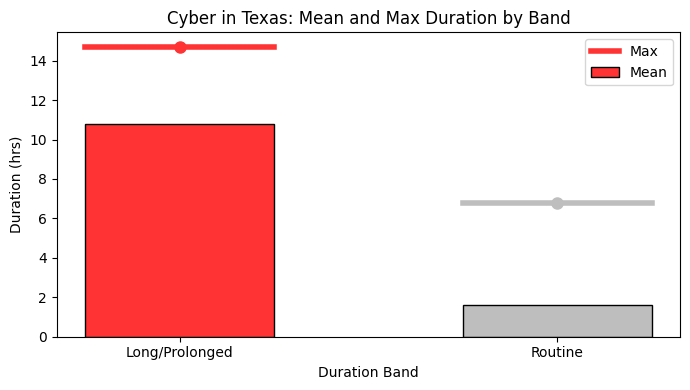

In [ ]:
# Plot mean and max for each theme/state from simulation results

def plot_customer_bands(summary_df, band_col, title, exclude_routine=False):
    summary_df = summary_df.copy()
    if exclude_routine:
        summary_df = summary_df[~summary_df[band_col].isin(["Routine"])]
    summary_df['max'] = summary_df['max'].round(0).astype(int)
    order = [b for b in CUSTOMER_BAND_COLORS if b in summary_df[band_col].values]
    colors = [CUSTOMER_BAND_COLORS[b] for b in order]
    maxs = summary_df.set_index(band_col).loc[order]['max']

    plt.figure(figsize=(8, 4))
    plt.bar(order, maxs, color=colors, edgecolor="black")
    plt.title(title)
    plt.ylabel("Max Customers")
    plt.xlabel("Customer Band")
    plt.tight_layout()
    plt.show()

def plot_duration_bands(summary_df, band_col, title, exclude_routine=False):
    import numpy as np
    summary_df = summary_df.copy()
    if exclude_routine:
        summary_df = summary_df[~summary_df[band_col].isin(["Routine"])]
    summary_df['mean'] = summary_df['mean'].round(1)
    summary_df['max'] = summary_df['max'].round(1)
    order = [b for b in DURATION_BAND_COLORS if b in summary_df[band_col].values]
    colors = [DURATION_BAND_COLORS[b] for b in order]
    x = np.arange(len(order))
    bar_width = 0.5
    means = summary_df.set_index(band_col).loc[order]['mean']
    maxs = summary_df.set_index(band_col).loc[order]['max']

    plt.figure(figsize=(7, 4))
    # Mean: solid bar
    plt.bar(x, means, width=bar_width, color=colors, edgecolor="black", label='Mean')
    # Max: line or marker
    for i, (xi, maxval, color) in enumerate(zip(x, maxs, colors)):
        plt.plot([xi - bar_width/2, xi + bar_width/2], [maxval, maxval], color=color, lw=4, label='Max' if i==0 else "")
        plt.plot([xi], [maxval], marker='o', color=color, markersize=8)
    plt.xticks(x, order)
    plt.title(title)
    plt.ylabel("Duration (hrs)")
    plt.xlabel("Duration Band")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.show()

# Plot for each theme/state from simulation results
for test in simulation_results:
    theme = test['theme'].iloc[0]
    state = test['state'].iloc[0]

    cust_summary = test.groupby('customer_band', observed=False)['pred_max_customers_calib'].agg(['count','mean','max']).reset_index()
    cust_summary['max'] = cust_summary['max'].round(0).astype(int)
    cust_summary['customer_band'] = pd.Categorical(cust_summary['customer_band'], categories=CUSTOMER_ORDER, ordered=True)
    cust_summary = cust_summary.sort_values('customer_band')

    dur_summary = test.groupby('duration_band', observed=False)['pred_duration'].agg(['count','mean','max']).reset_index()
    dur_summary['mean'] = dur_summary['mean'].round(1)
    dur_summary['max'] = dur_summary['max'].round(1)
    dur_summary['duration_band'] = pd.Categorical(dur_summary['duration_band'], categories=DURATION_ORDER, ordered=True)
    dur_summary = dur_summary.sort_values('duration_band')

    plot_customer_bands(
        cust_summary, 'customer_band',
        f"{theme.title()} in {state.title()}: Max Impacted Customers by Band",
        exclude_routine=False
    )
    plot_duration_bands(
        dur_summary, 'duration_band',
        f"{theme.title()} in {state.title()}: Mean and Max Duration by Band",
        exclude_routine=False
    )

In [ ]:
# bootstrap-based uncertainty analysis for the predictions from simulation

# Number of bootstrap samples
n_boot = 1000

# Bootstrap uncertainty for mean/max predicted customers
cust_means = []
cust_maxes = []
for i in range(n_boot):
    boot = test.sample(frac=1.0, replace=True)
    cust_means.append(boot['pred_max_customers_calib'].mean())
    cust_maxes.append(boot['pred_max_customers_calib'].max())
cust_mean_ci = np.percentile(cust_means, [2.5, 97.5])
cust_max_ci = np.percentile(cust_maxes, [2.5, 97.5])

# Bootstrap uncertainty for mean/max predicted durations
dur_means = []
dur_maxes = []
for i in range(n_boot):
    boot = test.sample(frac=1.0, replace=True)
    dur_means.append(boot['pred_duration'].mean())
    dur_maxes.append(boot['pred_duration'].max())
dur_mean_ci = np.percentile(dur_means, [2.5, 97.5])
dur_max_ci = np.percentile(dur_maxes, [2.5, 97.5])

# Display results
display(Markdown(f"""
**Bootstrap Uncertainty Estimates (n={n_boot}):**

- Mean predicted customers: {np.mean(cust_means):.0f}
  95% CI: [{cust_mean_ci[0]:.0f}, {cust_mean_ci[1]:.0f}]
- Max predicted customers: {np.mean(cust_maxes):.0f}
  95% CI: [{cust_max_ci[0]:.0f}, {cust_max_ci[1]:.0f}]

- Mean predicted duration (hrs): {np.mean(dur_means):.1f}
  95% CI: [{dur_mean_ci[0]:.1f}, {dur_mean_ci[1]:.1f}]
- Max predicted duration (hrs): {np.mean(dur_maxes):.1f}
  95% CI: [{dur_max_ci[0]:.1f}, {dur_max_ci[1]:.1f}]
"""))


**Bootstrap Uncertainty Estimates (n=1000):**

- Mean predicted customers: 1529
  95% CI: [801, 2964]
- Max predicted customers: 197310
  95% CI: [3534, 305122]

- Mean predicted duration (hrs): 1.8
  95% CI: [1.6, 1.9]
- Max predicted duration (hrs): 13.7
  95% CI: [9.7, 14.7]


In [ ]:
# Monte Carlo simulation to assess scenario-level uncertainty in  model predictions

n_mc = 1000  # Number of Monte Carlo runs

mc_cust_means = []
mc_cust_maxes = []
mc_dur_means = []
mc_dur_maxes = []

for i in range(n_mc):
    # Random train/test split each run
    train_mc = cdf.sample(frac=0.7, random_state=None)
    test_mc = cdf.drop(train_mc.index)

    # Customer Model
    X_train_mc = pd.get_dummies(train_mc[customer_features], columns=cat_cols_cust, drop_first=True)
    X_test_mc = pd.get_dummies(test_mc[customer_features], columns=cat_cols_cust, drop_first=True)
    X_test_mc = X_test_mc.reindex(columns=X_train_mc.columns, fill_value=0)
    y_train_mc = train_mc['max_customers']
    y_test_mc = test_mc['max_customers']

    cust_model_mc = fit_regressor(X_train_mc, y_train_mc, method='xgb')
    y_test_pred_cust_mc = cust_model_mc.predict(X_test_mc)
    iso_cust_mc = fit_calibrator(y_test_pred_cust_mc, y_test_mc)
    y_test_pred_cust_calib_mc = iso_cust_mc.transform(y_test_pred_cust_mc)

    mc_cust_means.append(np.mean(y_test_pred_cust_calib_mc))
    mc_cust_maxes.append(np.max(y_test_pred_cust_calib_mc))

    # Duration Model
    train_mc['log_duration'] = np.log1p(train_mc['duration_hours'])
    test_mc['log_duration'] = np.log1p(test_mc['duration_hours'])
    X_train_dur_mc = pd.get_dummies(train_mc[duration_features], columns=cat_cols_dur, drop_first=True)
    X_test_dur_mc = pd.get_dummies(test_mc[duration_features], columns=cat_cols_dur, drop_first=True)
    X_test_dur_mc = X_test_dur_mc.reindex(columns=X_train_dur_mc.columns, fill_value=0)
    y_train_dur_mc = train_mc['log_duration']
    y_test_dur_mc = test_mc['log_duration']

    dur_model_mc = fit_regressor(X_train_dur_mc, y_train_dur_mc, method='xgb')
    y_test_pred_dur_mc = dur_model_mc.predict(X_test_dur_mc)
    y_test_pred_dur_exp_mc = np.expm1(y_test_pred_dur_mc)

    mc_dur_means.append(np.mean(y_test_pred_dur_exp_mc))
    mc_dur_maxes.append(np.max(y_test_pred_dur_exp_mc))

# Confidence intervals
mc_cust_mean_ci = np.percentile(mc_cust_means, [2.5, 97.5])
mc_cust_max_ci = np.percentile(mc_cust_maxes, [2.5, 97.5])
mc_dur_mean_ci = np.percentile(mc_dur_means, [2.5, 97.5])
mc_dur_max_ci = np.percentile(mc_dur_maxes, [2.5, 97.5])

display(Markdown(f"""
**Monte Carlo Scenario Uncertainty Estimates (n={n_mc}):**

- Mean predicted customers: {np.mean(mc_cust_means):.0f}
  95% CI: [{mc_cust_mean_ci[0]:.0f}, {mc_cust_mean_ci[1]:.0f}]
- Max predicted customers: {np.mean(mc_cust_maxes):.0f}
  95% CI: [{mc_cust_max_ci[0]:.0f}, {mc_cust_max_ci[1]:.0f}]

- Mean predicted duration (hrs): {np.mean(mc_dur_means):.1f}
  95% CI: [{mc_dur_mean_ci[0]:.1f}, {mc_dur_mean_ci[1]:.1f}]
- Max predicted duration (hrs): {np.mean(mc_dur_maxes):.1f}
  95% CI: [{mc_dur_max_ci[0]:.1f}, {mc_dur_max_ci[1]:.1f}]
"""))


**Monte Carlo Scenario Uncertainty Estimates (n=1000):**

- Mean predicted customers: 1609  
  95% CI: [980, 2518]
- Max predicted customers: 145186  
  95% CI: [20932, 305122]

- Mean predicted duration (hrs): 1.8  
  95% CI: [1.6, 1.9]
- Max predicted duration (hrs): 17.5  
  95% CI: [11.4, 27.0]


In [ ]:
# Spatial summary by county - Top 10 counties by max predicted customers and outage duration
all_sim = pd.concat(simulation_results, ignore_index=True)

# Group by state and county for both metrics
county_summary = all_sim.groupby(['state','county']).agg(
    mean_customers=('pred_max_customers_calib', 'mean'),
    max_customers=('pred_max_customers_calib', 'max'),
    mean_duration=('pred_duration', 'mean'),
    max_duration=('pred_duration', 'max')
).reset_index()

# Round for readability
county_summary['mean_customers'] = county_summary['mean_customers'].round(0).astype(int)
county_summary['max_customers'] = county_summary['max_customers'].round(0).astype(int)
county_summary['mean_duration'] = county_summary['mean_duration'].round(1)
county_summary['max_duration'] = county_summary['max_duration'].round(1)

# Sort by max customers or max duration (choose one)
top_counties = county_summary.sort_values('max_customers', ascending=False).head(10)

print("\nTop 10 counties by max predicted customers and outage duration:\n")
display(top_counties)


Top 10 counties by max predicted customers and outage duration:



,state,county,mean_customers,max_customers,mean_duration,max_duration
100,florida,Miami-Dade,141820,1777800,3.1,48.799999
63,florida,Broward,122059,1398920,3.2,49.900002
107,florida,Palm Beach,93356,1098160,3.6,49.700001
72,florida,Duval,143702,528830,2.8,25.900000
62,florida,Brevard,73817,522288,5.9,50.700001
92,florida,Lee,121806,457817,5.5,47.200001
307,texas,Harris,7790,455986,2.4,25.600000
68,florida,Collier,123982,401458,6.2,45.900002
422,texas,Tarrant,2616,367316,2.2,32.099998
264,texas,Dallas,3269,358650,2.4,32.900002


---
**Patterns & Risks Across All Types**

- Weather is clearly the principal driver of extreme outages.
- Grid issues and other events are less frequent or severe, but can occasionally rival weather.
- Routine events are numerically dominant, but emergency planning should focus on rare, severe occurrences.

- Uncertainty analysis (Bootstrap & Monte Carlo) confirms the risk of rare, high-impact incidents:  
  - Maximum impact and duration have wide confidence intervals.
  - Planning should account for uncertainty, not merely averages. Whilst bootstrap and Monte Carlo analyses quantify uncertainty in predicted outage impacts and durations, their results are dominated by the large proportion of routine events. As a consequence, mean values and most confidence intervals primarily reflect typical outcomes, whilst the true risk lies in the rare, extreme occurrences,the maximums and upper bounds,which are most relevant for contingency planning.

---

**A. Weather Events**

*States: Texas, Michigan, Florida, California*

---

- Most impactful: Weather events result in the highest customer outages and longest durations.
- Florida:
  - Maximum impacted customers (Critical band): ~1.8 million
  - Maximum outage duration: 111 hours (~4.5 days)
- Texas & Michigan:  
  - Maximum customers: 456k (Texas), 265k (Michigan)
  - Maximum durations: 80 hours (Texas), 69 hours (Michigan)
- California:  
  - Lower but still notable: 122k customers, 33 hours maximum duration
- Routine events: Most are small, but rare, extreme events dominate outage risk.

---

*Bootstrap & Monte Carlo Uncertainty*

- The majority of weather-related outages fall within the lower to middle segments of the confidence intervals. Rare but severe events such as major hurricanes, can reach or even exceed the upper bounds of predicted customer impact and duration, reinforcing the need for robust contingency planning for these extremes.

---
*Practical Implications*
- Emergency planning should focus on weather events, especially in Florida, Texas, and Michigan, with resources scaled for multi-day, mass outages.
- Preparedness for rare, extreme events is essential.  
  The wide confidence intervals for maximum customers and durations illustrate considerable uncertainty—response plans should be robust and flexible.

---

**B. Grid Issue Events**

*States: Texas, California, Florida*

---

- Lower impact than weather, but not negligible.
- Texas & California: Occasional spikes  
  - Maximum customers: 305k (Texas), 89k (California)
  - Maximum durations: 22 hours (both)
- Florida grid issues:
  - Small scale, maximum ~3,400 customers.
- Most events are short, but a minority of long or prolonged outages exist.

---

*Bootstrap & Monte Carlo Uncertainty*

- Customer and duration estimates for grid events generally fall within the lower end of the confidence intervals described above, but rare spikes can overlap with severe weather event ranges.

---

*Practical Implications*
- Grid failures can cause substantial outages in rare cases.  
- Response plans should include grid failures, especially in Texas and California.  
- Most events are manageable, but spikes can rival severe weather.

---

**C. Other Events (Cyber, Fuel, Attack)**

*States: Texas, California*

---

- Generally less significant for both customer impact and duration.
- Rare spikes:
  - Cyber in Texas: maximum 305k customers
  - Fuel in California: maximum 104k customers
- Most attack events are low impact.
- Prolonged outages rarely exceed ~25 hours.

---

*Bootstrap & Monte Carlo Uncertainty*
- Most events cluster at the lower end of uncertainty bands, but rare occurrences can push maximum impact and duration towards the higher bounds observed in weather and grid events.

---

*Practical Implications*
- Monitor for rare, severe occurrences, but routine protocols are usually sufficient.
- Contingency plans must exist for exceptional cases, even though these are not a dominant source of risk.

---

**D. Spatial Summary: County-Level Outage Risk**

In addition to state-level analysis, spatial granularity reveals concentrated risk in specific counties,most notably in Florida and Texas,where both the highest predicted customer impacts and longest outages occur.

*Top 10 counties by maximum predicted customers and outage duration:*

| state   | county      | mean_customers | max_customers | mean_duration | max_duration |
|---------|-------------|----------------|---------------|---------------|--------------|
| florida | Miami-Dade  | 141,820        | 1,777,800     | 3.1           | 48.8         |
| florida | Broward     | 122,059        | 1,398,920     | 3.2           | 49.9         |
| florida | Palm Beach  | 93,356         | 1,098,160     | 3.6           | 49.7         |
| florida | Duval       | 143,702        | 528,830       | 2.8           | 25.9         |
| florida | Brevard     | 73,817         | 522,288       | 5.9           | 50.7         |
| florida | Lee         | 121,806        | 457,817       | 5.5           | 47.2         |
| texas   | Harris      | 7,790          | 455,986       | 2.4           | 25.6         |
| florida | Collier     | 123,982        | 401,458       | 6.2           | 45.9         |
| texas   | Tarrant     | 2,616          | 367,316       | 2.2           | 32.1         |
| texas   | Dallas      | 3,269          | 358,650       | 2.4           | 32.9         |

**Implications:**
- Outage risk is highly concentrated in several Florida counties (Miami-Dade, Broward, Palm Beach), dwarfing other regions in both impact and duration.
- Texas counties (Harris, Tarrant, Dallas) also appear in the top 10, confirming the need for targeted resilience and emergency planning at the local level.
- This spatial detail supports more effective resource allocation and stakeholder coordination for future outage scenarios.

---